In [1]:
# -*- coding: utf-8 -*-

"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta
Modified by: Tommaso Tabarelli

Lab. 03 - Introduction to PyTorch (part 2)
 
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import skorch

import torch
import torch.nn as nn
import torch.optim as optim

<class 'dict'>

----------

__header__
__version__
__globals__
input_images
output_labels

----------

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov  4 16:38:51 2019'
1.0
[]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [8.]
 [4.]
 ...
 [9.]
 [2.]
 [1.]]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 784)
(60000, 1)

Label:  2


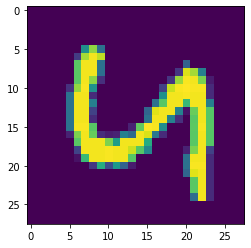

In [2]:
# Set random seed
np.random.seed(3123)

# Loading MNIST data
MNIST_ = scipy.io.loadmat('MNIST.mat')

# Inspecting the MNIST data type and format

print(type(MNIST_))

print("\n----------\n")

for kk,vv in zip(MNIST_.keys(), MNIST_.values()):
    print(kk)

print("\n----------\n")
    
for kk,vv in zip(MNIST_.keys(), MNIST_.values()):
    print(vv)


print("")
MNIST_imgs = MNIST_['input_images']
MNIST_labels = MNIST_['output_labels']

print(type(MNIST_imgs))
print(type(MNIST_labels))

print(MNIST_imgs.shape)
print(MNIST_labels.shape)


# Visualizing images

index_try = 91

print("\nLabel: ", int(MNIST_labels[index_try][0]))
plt.imshow(MNIST_imgs[index_try].reshape(28,28))
plt.show()

Label:  9


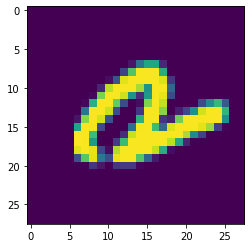

In [3]:
# Copying and shuffling
X = MNIST_imgs.copy()
Y = np.array(MNIST_labels.copy(), dtype='long')

# Shuffling data and labels using the same seed
np.random.seed(3123)
np.random.shuffle(X)
np.random.seed(3123)
np.random.shuffle(Y)

# Checking labels are still coherent
index_try = 91

print("Label: ", int(Y[index_try]))
plt.imshow(X[index_try].reshape(28,28))
plt.show()

In [4]:
# Splitting train 5/6*len(MNIST_data) - test 1/6*len(MNIST_data)
x_train = X[:int(5.*len(MNIST_imgs)/6)]
y_train = Y[:int(5.*len(MNIST_labels)/6)]

x_test = X[int(5.*len(MNIST_imgs)/6):]
y_test = Y[int(5.*len(MNIST_labels)/6):]

# Checking
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

50000
50000
10000
10000


In [5]:
#%% Neural Network

### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, act_func):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = act_func()
        
        
    def forward(self, x, additional_out=False):
        
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        out = nn.functional.softmax(out, dim=-1)
        
        if additional_out:
            return out, np.argmax(out)
        
        return out


In [6]:
y_train.shape

(50000, 1)

In [7]:
# Splitting train test
tot = len(x_train)
mask = np.array(np.ones(tot), "bool")

# Creating a list of train-validation
x_train_sets = []
x_valid_sets = []
y_train_sets = []
y_valid_sets = []

# Splitting into 5 pieces
k_ = 5

for j in range(k_):
    # modifying mask
    temp_mask = mask.copy()
    temp_mask[(j*int(np.round(tot/k_))):((j+1)*int(np.round(tot/k_)))] = False
    x_train_sets.append(x_train[temp_mask])
    x_valid_sets.append(x_train[~temp_mask])
    y_train_sets.append(y_train[temp_mask])
    y_valid_sets.append(y_train[~temp_mask])

x_train_sets = np.array(x_train_sets)
y_train_sets = np.array(y_train_sets)
x_valid_sets = np.array(x_valid_sets)
y_valid_sets = np.array(y_valid_sets)

In [8]:
x_train_sets.shape

(5, 40000, 784)

In [9]:
from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)

my_net = skorch.NeuralNetClassifier(
    module=Net,
    module__Ni= 784,
    module__Nh1 = 24,
    module__Nh2 = 12,
    module__No = 10,
    module__act_func = nn.Sigmoid,
    lr = 1e-3,
    optimizer = torch.optim.Adam,
    #loss = nn.CrossEntropyLoss(),
    max_epochs = 200,
    batch_size = 1000,
    callbacks = [my_early])

### Try to fit using "my_net"

### N.B.: this search lasts about 3 hours, so do not start it if you only want to see the results

In [10]:
from sklearn.model_selection import GridSearchCV

In [19]:
params = {
    'lr': [0.1, 0.01, 0.001],
    'module__Nh1': [24,48,96],
    'module__Nh2': [12,24,48],
    'max_epochs': [500],
    #'module__act_func': [nn.Sigmoid, nn.ReLU, nn.ReLU6, nn.Tanh, nn.LeakyReLU]
    'module__act_func': [nn.Sigmoid, nn.ReLU, nn.Tanh]
}
gs = GridSearchCV(my_net, params, refit=False, cv=5)

gs.fit(x_train, y_train.squeeze())

print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8087       0.7056        1.0399  0.3976
      2        0.7439       0.8448        0.5723  0.4293
      3        0.4818       0.8731        0.4643  0.4350
      4        0.4090       0.8837        0.4392  0.4367
      5        0.3735       0.8982        0.3972  0.4458
      6        0.3435       0.8976        0.3903  0.4492
      7        0.3277       0.9018        0.3814  0.8607
      8        0.3224       0.9067        0.3527  0.4382
      9        0.3042       0.9074        0.3608  0.4427
     10        0.2901       0.9080        0.3517  0.4436
     11        0.2671       0.9155        0.3425  0.4463
     12        0.2655       0.9149        0.3408  0.4470
     13        0.2586       0.9070        0.3597  0.4433
     14        0.2580       0.9168        0.3330  0.4488
     15        0.2406       0.9177        0.3331  0.5003
     16        0.2383       0.9

Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5319       0.6685        0.9158  0.4048
      2        0.7652       0.7863        0.6870  0.4504
      3           nan       0.0987           nan  0.4027
      4           nan       0.0987           nan  0.4114
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9427       0.8534        0.5312  0.4134
      2        0.4699       0.8841        0.4224  0.4564
      3        0.3995       0.8848        0.4195  0.4353
      4        0.3653       0.9000        0.3780  0.3987
      5        0.3461       0.9012        0.3675  0.4073
      6        0.3260       0.8949        0.3728  0.4094
      7        0.3261       0.9027        0.3719  0.4137
      8        

     10        0.2997       0.8964        0.3466  0.4504
     11        0.2905       0.9093        0.3217  0.4427
     12        0.2785       0.9087        0.3219  0.4467
     13        0.2646       0.9112        0.3137  0.4442
     14        0.2600       0.9118        0.3218  0.4916
     15        0.2470       0.9129        0.3031  0.4424
     16        0.2431       0.9089        0.3208  0.4421
     17        0.2423       0.9142        0.3063  0.4447
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6702       0.7491        0.9083  0.4170
      2        0.6097       0.8771        0.4305  0.4279
      3        0.4004       0.8973        0.3787  0.4803
      4        0.3332       0.8997        0.3575  0.4367
      5        0.3057       0.9108        0.3134  0.4387
      6        0.2728       0.9118        0.3061  0.7895
      7        0.2672  

      3        0.3806       0.8875        0.4082  0.7417
      4        0.3548       0.8970        0.3733  0.7348
      5        0.3277       0.9019        0.3436  0.7428
      6        0.3141       0.9074        0.3348  0.7322
      7        0.3171       0.9049        0.3311  0.8144
      8        0.2837       0.9091        0.3123  0.4033
      9        0.2819       0.9117        0.3213  0.4075
     10        0.2721       0.9174        0.3024  0.4122
     11        0.2612       0.9076        0.3204  0.4139
     12        0.2708       0.9117        0.3015  0.4585
     13        0.2873       0.9143        0.3129  0.4140
     14        0.2616       0.9161        0.2987  0.4096
     15        0.2536       0.9171        0.2959  0.4126
     16        0.2626       0.9139        0.3116  0.4125
     17        0.2771       0.9116        0.3046  0.4119
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  

     14        0.3205       0.9011        0.3702  0.7780
     15        0.3151       0.9088        0.3571  0.7755
     16        0.3205       0.8991        0.3826  0.7768
     17        0.3178       0.9061        0.3618  0.7736
     18        0.3008       0.9112        0.3448  0.7762
     19        0.2866       0.9099        0.3409  0.7799
     20        0.2822       0.9089        0.3572  0.8600
     21        0.2802       0.9123        0.3407  0.4390
     22        0.2763       0.9122        0.3488  0.4418
     23        0.2736       0.9081        0.3550  0.4511
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1530       0.4574        1.5761  0.4155
      2        0.9817       0.7785        0.6615  0.7811
      3        0.5503       0.8742        0.4704  0.4411
      4        0.4276       0.8820        0.4256  0.4506
      5        0.3960  

      4        0.3040       0.9109        0.3210  0.8205
      5        0.2802       0.9109        0.3184  0.7389
      6        0.2784       0.9164        0.3103  0.7375
      7        0.2538       0.9154        0.3160  0.7377
      8        0.2718       0.9077        0.3199  0.7426
      9        0.2659       0.9169        0.2934  0.8178
     10        0.2573       0.9204        0.2915  0.7391
     11        0.2559       0.9048        0.3311  0.7432
     12        0.2522       0.9098        0.3207  0.7352
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0163       0.8384        0.5471  0.7307
      2        0.4336       0.8868        0.4007  0.7402
      3        0.3465       0.8878        0.3829  0.7370
      4        0.3159       0.9092        0.3239  0.7359
      5        0.2906       0.9053        0.3349  0.4078
      6        0.2913  

     13        0.2034       0.9321        0.2651  0.5179
     14        0.1963       0.9293        0.2640  0.5182
     15        0.1911       0.9298        0.2800  0.8513
     16        0.1956       0.9273        0.2723  0.5169
     17        0.1910       0.9324        0.2625  0.8671
     18        0.1964       0.9251        0.2791  0.8596
     19        0.1926       0.9331        0.2519  0.8547
     20        0.1877       0.9248        0.2865  0.5229
     21        0.1760       0.9319        0.2689  0.5717
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8046       0.5933        1.0715  0.6649
      2           nan       0.0987           nan  0.4218
      3           nan       0.0987           nan  0.4308
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------

      5        0.2971       0.9149        0.3336  0.5009
      6        0.2695       0.9088        0.3336  0.7599
      7        0.2516       0.9189        0.3104  0.6245
      8        0.2436       0.9209        0.2909  0.4985
      9        0.2271       0.9247        0.2762  0.5134
     10        0.2174       0.9207        0.2946  0.5072
     11        0.2074       0.9268        0.2729  0.5078
     12        0.1945       0.9317        0.2603  0.5096
     13        0.1872       0.9294        0.2629  0.5105
     14        0.1996       0.9223        0.2827  0.5107
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8668       0.6249        1.2056  0.4360
      2        0.8637       0.8756        0.5748  0.4569
      3        0.4654       0.8918        0.4266  0.4664
      4        0.3709       0.8989        0.3803  0.4725
      5        0.3356  

      9        0.3147       0.8898        0.3908  0.5342
     10        0.3276       0.8821        0.4257  0.8810
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0987           nan  0.7957
      2           nan       0.0987           nan  0.8039
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6535       0.7268        0.8226  0.7774
      2        0.6836       0.7899        0.6232  0.7739
      3        0.5652       0.8208        0.5528  0.7754
      4        0.5177       0.8412        0.5394  0.7650
      5        0.4875       0.8521        0.5161  0.7817
      6        0.4767       0.8435        0.5222  0.7704
      7        0.4640       0.8500        0.5093  0.4307
      8        

      5        0.2538       0.9217        0.2840  0.8221
      6        0.2350       0.9163        0.2885  0.8220
      7        0.2259       0.9302        0.2529  0.8265
      8        0.2047       0.9278        0.2608  0.8359
      9        0.2045       0.9293        0.2534  0.9150
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0127       0.5215        1.3304  0.7951
      2        0.9984       0.7760        0.7140  0.8405
      3        0.5578       0.8760        0.4466  0.8468
      4        0.3958       0.8922        0.3953  0.8518
      5        0.3205       0.9114        0.3298  0.8589
      6        0.3058       0.8966        0.3603  0.8587
      7        0.2805       0.9087        0.3228  0.8594
      8        0.2655       0.9061        0.3306  0.8591
      9        0.2556       0.9123        0.3123  0.8568
     10        0.2397  

      5        0.2731       0.9182        0.2760  0.4263
      6        0.2648       0.9168        0.2796  0.4441
      7        0.2460       0.9249        0.2646  0.4882
      8        0.2284       0.9283        0.2461  0.4275
      9        0.2245       0.9299        0.2409  0.4352
     10        0.2353       0.9264        0.2432  0.4361
     11        0.2149       0.9288        0.2416  0.4275
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9844       0.8596        0.4679  0.8837
      2        0.3802       0.8936        0.3517  0.4784
      3        0.3307       0.8952        0.3525  0.4921
      4        0.2970       0.9048        0.3241  0.6030
      5        0.2829       0.9186        0.2881  0.9732
      6        0.2656       0.9187        0.2789  0.7926
      7        0.2619       0.9213        0.2876  0.8428
      8        0.2697  

      5        1.3017       0.5127        1.2531  0.9669
      6        1.1764       0.5587        1.1712  0.9697
      7        1.1368       0.5513        1.1660  0.9791
      8        1.1152       0.5295        1.1312  0.9809
      9        1.0710       0.5411        1.0874  1.0613
     10        1.0357       0.5982        1.0606  0.9728
     11        1.0027       0.6588        1.0059  0.9640
     12        0.9521       0.6157        0.9984  0.9773
     13        0.9121       0.6929        0.9182  0.9775
     14        0.8656       0.7311        0.8973  0.6713
     15        0.8409       0.6653        0.8961  0.6153
     16        0.8394       0.7003        0.8976  0.6129
     17        0.8119       0.6862        0.8923  0.6170
     18        0.8064       0.7313        0.8726  0.6116
     19        0.7906       0.6776        0.9084  0.6170
     20        0.7609       0.7117        0.8185  0.6174
     21        0.7445       0.6802        0.9025  0.6128
     22        0.7429       0.7

      2        1.1221       0.5507        1.0618  0.4811
      3        1.0569       0.5524        1.0194  0.4798
      4        0.9803       0.6199        0.9310  0.5329
      5        0.8479       0.7740        0.7582  0.4779
      6        0.7672       0.7595        0.7580  0.4798
      7        0.7191       0.7864        0.6853  0.4803
      8        0.6850       0.7881        0.7013  0.4916
      9        0.6665       0.8005        0.6517  0.4819
     10        0.6722       0.7994        0.6406  0.4846
     11        0.6297       0.8035        0.6453  0.5373
     12        0.6485       0.7950        0.6639  0.4818
     13        0.6327       0.8130        0.6086  0.4851
     14        0.5934       0.8070        0.6128  0.4800
     15        0.6205       0.8096        0.5977  0.4869
     16        0.6461       0.8069        0.6357  0.4810
     17        0.6073       0.8042        0.6556  0.4842
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss  

      3        0.3628       0.9074        0.3554  0.9738
      4        0.2973       0.9198        0.2980  1.0657
      5        0.2542       0.9259        0.2796  0.6468
      6        0.2213       0.9318        0.2482  0.6522
      7        0.2096       0.9390        0.2280  0.6557
      8        0.1896       0.9395        0.2287  0.6661
      9        0.1888       0.9400        0.2220  0.6668
     10        0.1735       0.9379        0.2245  0.8720
     11        0.1672       0.9439        0.2076  0.6608
     12        0.1656       0.9443        0.2006  0.7179
     13        0.1543       0.9442        0.2107  0.6714
     14        0.1501       0.9480        0.1877  0.6798
     15        0.1481       0.9425        0.2069  0.6753
     16        0.1350       0.9489        0.1940  0.6723
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9734  

     11        0.3594       0.8951        0.3762  0.4910
     12        0.3436       0.9074        0.3501  0.4865
     13        0.3508       0.8878        0.3918  0.5323
     14        0.3466       0.8987        0.3666  0.4604
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9451       0.8606        0.4745  0.4083
      2        0.4104       0.8897        0.3871  0.4092
      3        0.3556       0.8942        0.3538  0.4533
      4        0.3383       0.8977        0.3519  0.4126
      5        0.3358       0.8795        0.3953  0.4101
      6        0.3558       0.9024        0.3576  0.4064
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1205       0.8359        0.5986  0.5396
      2        

      2           nan       0.0987           nan  0.9073
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.6024       0.6140        0.9944  0.8216
      2           nan       0.0987           nan  0.6846
      3           nan       0.0987           nan  0.6893
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0987           nan  0.6919
      2           nan       0.0987           nan  0.6979
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0987           nan  0.7663
      2           nan       0.0987           nan  0.6974
Stoppin

     19        0.1147       0.9390        0.2090  0.3470
     20        0.1111       0.9383        0.2104  0.3423
     21        0.1080       0.9389        0.2116  0.3872
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0566       0.4973        1.6982  0.3469
      2        1.3675       0.7562        1.0650  0.3451
      3        0.8669       0.8310        0.7059  0.3882
      4        0.5930       0.8844        0.5142  0.3413
      5        0.4393       0.9026        0.4030  0.3411
      6        0.3502       0.9128        0.3418  0.3417
      7        0.2968       0.9176        0.3053  0.3419
      8        0.2611       0.9223        0.2819  0.3416
      9        0.2346       0.9245        0.2654  0.3417
     10        0.2134       0.9270        0.2541  0.3413
     11        0.1957       0.9292        0.2454  0.3415
     12        0.1809  

Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0849       0.8536        0.4980  0.6094
      2        0.4085       0.8981        0.3482  0.6193
      3        0.3051       0.9157        0.2898  0.6174
      4        0.2588       0.9270        0.2578  0.6267
      5        0.2285       0.9320        0.2371  0.7261
      6        0.2035       0.9360        0.2231  0.7297
      7        0.1835       0.9390        0.2119  0.6715
      8        0.1677       0.9434        0.2024  0.6174
      9        0.1541       0.9447        0.1963  0.6132
     10        0.1424       0.9464        0.1925  0.6139
     11        0.1324       0.9463        0.1906  0.3413
     12        0.1237       0.9465        0.1896  0.3414
     13        0.1157       0.9484        0.1874  0.3410
     14        0.1089       0.9498        0.1846  0.3400
     15        0.1025  

      9        0.1430       0.9370        0.2185  0.6841
     10        0.1293       0.9355        0.2241  0.6227
     11        0.1268       0.9328        0.2281  0.6148
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2290       0.8618        0.6033  0.3450
      2        0.4483       0.9084        0.3439  0.3883
      3        0.2974       0.9217        0.2773  0.3415
      4        0.2386       0.9302        0.2505  0.3434
      5        0.2098       0.9330        0.2391  0.3413
      6        0.1836       0.9340        0.2295  0.3431
      7        0.1634       0.9357        0.2217  0.3433
      8        0.1480       0.9388        0.2098  0.3417
      9        0.1418       0.9409        0.2105  0.3877
     10        0.1373       0.9385        0.2182  0.3441
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    trai

     10        0.1701       0.9378        0.2201  0.6255
     11        0.1559       0.9394        0.2098  0.6244
     12        0.1443       0.9418        0.2028  0.6249
     13        0.1343       0.9420        0.1981  0.6193
     14        0.1259       0.9423        0.1946  0.6221
     15        0.1187       0.9427        0.1921  0.6258
     16        0.1121       0.9440        0.1907  0.7271
     17        0.1061       0.9454        0.1902  0.6467
     18        0.1006       0.9457        0.1903  0.6507
     19        0.0957       0.9458        0.1897  0.7319
     20        0.0915       0.9473        0.1879  0.4266
     21        0.0880       0.9482        0.1861  0.4290
     22        0.0850       0.9480        0.1863  0.4314
     23        0.0827       0.9475        0.1886  0.4300
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9410  

      6        0.1658       0.9419        0.1883  0.6131
      7        0.1465       0.9445        0.1843  0.6191
      8        0.1319       0.9448        0.1815  0.3400
      9        0.1208       0.9442        0.1866  0.3427
     10        0.1137       0.9423        0.1953  0.4499
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0769       0.8541        0.4656  0.4069
      2        0.3799       0.9079        0.3125  0.4030
      3        0.2772       0.9246        0.2552  0.3443
      4        0.2318       0.9331        0.2304  0.3402
      5        0.2022       0.9380        0.2145  0.3398
      6        0.1792       0.9403        0.1998  0.4077
      7        0.1592       0.9415        0.1919  0.4111
      8        0.1450       0.9432        0.1892  0.4090
      9        0.1348       0.9442        0.1842  0.4595
     10        0.1267  

      7        0.1930       0.9295        0.2459  0.4163
      8        0.1750       0.9329        0.2348  0.4165
      9        0.1602       0.9345        0.2267  0.4747
     10        0.1470       0.9368        0.2223  0.4242
     11        0.1356       0.9378        0.2200  0.3590
     12        0.1263       0.9384        0.2176  0.3471
     13        0.1187       0.9397        0.2141  0.3467
     14        0.1129       0.9402        0.2108  0.3795
     15        0.1087       0.9409        0.2130  0.4138
     16        0.1055       0.9357        0.2247  0.4182
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8901       0.7230        1.2263  0.4195
      2        0.8325       0.8687        0.5401  0.4143
      3        0.4259       0.9059        0.3494  0.4167
      4        0.3034       0.9178        0.2891  0.3474
      5        0.2506  

      2        0.3255       0.9188        0.2787  0.3504
      3        0.2598       0.9223        0.2494  0.3442
      4        0.2171       0.9315        0.2234  0.3434
      5        0.1842       0.9370        0.2076  0.3434
      6        0.1631       0.9370        0.2055  0.3635
      7        0.1488       0.9344        0.2108  0.4067
      8        0.1384       0.9418        0.1914  0.4087
      9        0.1283       0.9494        0.1780  0.4581
     10        0.1113       0.9489        0.1779  0.4076
     11        0.1025       0.9504        0.1765  0.4019
     12        0.0957       0.9514        0.1734  0.5856
     13        0.0959       0.9525        0.1668  0.6175
     14        0.0893       0.9513        0.1752  0.6833
     15        0.0732       0.9514        0.1774  0.6816
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8729  

      2        0.2658       0.9314        0.2348  0.3769
      3        0.1980       0.9379        0.2093  0.6519
      4        0.1600       0.9458        0.1876  0.6243
      5        0.1341       0.9500        0.1730  0.6456
      6        0.1168       0.9490        0.1771  0.7050
      7        0.1023       0.9470        0.1812  0.8836
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9778       0.6099        1.5558  0.8648
      2        1.2556       0.8253        0.9775  0.8757
      3        0.7688       0.8844        0.6037  0.7530
      4        0.4879       0.9132        0.4189  0.6896
      5        0.3466       0.9253        0.3302  0.6626
      6        0.2709       0.9320        0.2821  0.6594
      7        0.2241       0.9387        0.2528  0.6656
      8        0.1916       0.9393        0.2343  0.7455
      9        0.1673  

      8        0.1769       0.9448        0.2127  0.6843
      9        0.1546       0.9475        0.1993  0.6847
     10        0.1368       0.9493        0.1897  0.6686
     11        0.1226       0.9499        0.1834  0.7553
     12        0.1110       0.9504        0.1788  0.6763
     13        0.1009       0.9512        0.1733  0.4342
     14        0.0919       0.9517        0.1681  0.4279
     15        0.0834       0.9520        0.1667  0.4340
     16        0.0758       0.9529        0.1653  0.5106
     17        0.0706       0.9530        0.1655  0.5285
     18        0.0668       0.9520        0.1695  0.5289
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9730       0.8851        0.3921  0.6668
      2        0.3046       0.9209        0.2721  0.4244
      3        0.2191       0.9347        0.2217  0.6698
      4        0.1772  

      9        0.0885       0.9437        0.2039  0.8282
     10        0.0881       0.9484        0.1800  0.8121
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1884       0.8615        0.6366  0.6814
      2        0.4467       0.9183        0.3210  0.6692
      3        0.2552       0.9382        0.2329  0.6740
      4        0.1871       0.9470        0.1955  0.8842
      5        0.1494       0.9464        0.1859  0.5267
      6        0.1196       0.9437        0.1883  0.4984
      7        0.1073       0.9509        0.1666  0.4392
      8        0.0969       0.9530        0.1678  0.4291
      9        0.0870       0.9474        0.1793  0.4303
     10        0.0805       0.9507        0.1662  0.4540
     11        0.0785       0.9502        0.1702  0.6697
     12        0.0692       0.9557        0.1590  0.6548
     13        0.0689  

      9        0.1287       0.9473        0.1791  0.7003
     10        0.1143       0.9494        0.1722  0.8266
     11        0.1027       0.9510        0.1656  0.5757
     12        0.0925       0.9525        0.1597  0.5259
     13        0.0836       0.9520        0.1566  0.5793
     14        0.0761       0.9522        0.1574  0.6932
     15        0.0702       0.9517        0.1608  0.4412
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7277       0.7546        1.0319  0.6778
      2        0.7207       0.8766        0.4961  0.6819
      3        0.3977       0.9122        0.3323  0.6939
      4        0.2861       0.9236        0.2714  0.7801
      5        0.2288       0.9335        0.2334  0.6885
      6        0.1910       0.9410        0.2081  0.6760
      7        0.1632       0.9467        0.1914  0.6915
      8        0.1415  

     12        0.0829       0.9564        0.1473  0.8971
     13        0.0779       0.9555        0.1641  0.7438
     14        0.0684       0.9589        0.1475  0.6797
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8632       0.9027        0.3424  0.6761
      2        0.2679       0.9307        0.2426  0.6817
      3        0.1845       0.9430        0.1990  0.7554
      4        0.1402       0.9490        0.1784  0.6775
      5        0.1099       0.9523        0.1699  0.6613
      6        0.0900       0.9520        0.1655  0.7691
      7        0.0826       0.9503        0.1811  0.6809
      8        0.0813       0.9538        0.1662  0.8824
      9        0.0788       0.9529        0.1650  0.4995
     10        0.0652       0.9526        0.1667  0.4260
     11        0.0549       0.9485        0.1797  0.4307
Stopping since valid_lo

      6        0.1595       0.9440        0.1839  0.7197
      7        0.1378       0.9492        0.1699  0.6446
      8        0.1203       0.9513        0.1599  0.6495
      9        0.1064       0.9528        0.1529  0.6501
     10        0.0949       0.9538        0.1467  0.6470
     11        0.0846       0.9554        0.1417  0.6473
     12        0.0758       0.9590        0.1369  0.6467
     13        0.0682       0.9597        0.1338  0.6493
     14        0.0618       0.9587        0.1329  0.7063
     15        0.0561       0.9584        0.1360  0.7718
     16        0.0515       0.9575        0.1395  0.7497
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6492       0.8136        0.7866  0.4321
      2        0.5083       0.8992        0.3593  0.7569
      3        0.2989       0.9241        0.2676  0.7760
      4        0.2249  

      6        0.1163       0.9457        0.1869  0.3624
      7        0.1029       0.9504        0.1737  0.3618
      8        0.0932       0.9549        0.1599  0.4617
      9        0.0875       0.9588        0.1496  0.4265
     10        0.0757       0.9575        0.1507  0.4337
     11        0.0726       0.9533        0.1691  0.4280
     12        0.0755       0.9613        0.1456  0.3882
     13        0.0648       0.9628        0.1540  0.3602
     14        0.0597       0.9608        0.1592  0.3583
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7428       0.9102        0.3052  0.4331
      2        0.2430       0.9344        0.2255  0.4351
      3        0.1710       0.9452        0.1887  0.4874
      4        0.1274       0.9470        0.1750  0.4349
      5        0.1010       0.9520        0.1661  0.4359
      6        0.0840  

     14        0.0615       0.9573        0.1492  0.7710
     15        0.0550       0.9545        0.1566  0.6883
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8528       0.7069        1.3395  0.6901
      2        1.0306       0.8536        0.7883  0.6936
      3        0.6448       0.9018        0.5155  0.6920
      4        0.4253       0.9238        0.3626  0.7219
      5        0.3079       0.9367        0.2859  0.6947
      6        0.2401       0.9437        0.2413  0.7945
      7        0.1940       0.9480        0.2107  0.6203
      8        0.1613       0.9528        0.1892  0.8233
      9        0.1361       0.9564        0.1757  0.7671
     10        0.1160       0.9570        0.1687  0.6916
     11        0.1008       0.9577        0.1621  0.6928
     12        0.0890       0.9613        0.1492  0.6930
     13        0.0791  

      2        0.2894       0.9275        0.2468  0.6860
      3        0.2002       0.9438        0.1950  0.6821
      4        0.1568       0.9460        0.1842  0.7434
      5        0.1283       0.9468        0.1811  0.6774
      6        0.1084       0.9562        0.1566  0.6994
      7        0.0988       0.9588        0.1502  0.8070
      8        0.0787       0.9611        0.1445  0.8060
      9        0.0653       0.9643        0.1338  0.8233
     10        0.0537       0.9649        0.1271  0.6760
     11        0.0436       0.9640        0.1361  0.6715
     12        0.0411       0.9624        0.1468  0.6792
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1030       0.8614        0.4641  0.7036
      2        0.3545       0.9219        0.2608  0.8969
      3        0.2159       0.9397        0.2005  0.7813
      4        0.1611  

      2        0.3687       0.9212        0.2967  0.6830
      3        0.2268       0.9438        0.2137  0.6828
      4        0.1683       0.9478        0.1916  0.7553
      5        0.1352       0.9489        0.1880  0.6832
      6        0.1098       0.9540        0.1640  0.6911
      7        0.0940       0.9540        0.1603  0.7726
      8        0.0839       0.9553        0.1608  0.8137
      9        0.0770       0.9563        0.1608  0.8137
     10        0.0633       0.9573        0.1477  0.4747
     11        0.0527       0.9580        0.1454  0.4460
     12        0.0473       0.9584        0.1546  0.4013
     13        0.0438       0.9568        0.1612  0.4041
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6417       0.7925        0.9211  0.4663
      2        0.6032       0.8991        0.4148  0.5353
      3        0.3212  

     15        0.0330       0.9670        0.1167  0.7350
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7908       0.8939        0.3688  0.5416
      2        0.2853       0.9233        0.2723  0.4728
      3        0.2004       0.9402        0.2125  0.3961
      4        0.1597       0.9475        0.1821  0.4195
      5        0.1318       0.9531        0.1637  0.4724
      6        0.1102       0.9563        0.1551  0.4707
      7        0.0906       0.9563        0.1519  0.4712
      8        0.0745       0.9563        0.1513  0.5851
      9        0.0636       0.9571        0.1479  0.6841
     10        0.0611       0.9524        0.1675  0.6769
     11        0.0616       0.9569        0.1537  0.6760
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------

      6        0.0748       0.9573        0.1398  0.4883
      7        0.0672       0.9539        0.1550  0.5319
      8        0.0671       0.9543        0.1543  0.4819
      9        0.0720       0.9610        0.1353  0.4571
     10        0.0545       0.9537        0.1575  0.4086
     11        0.0464       0.9572        0.1468  0.4067
     12        0.0426       0.9633        0.1337  0.4498
     13        0.0411       0.9578        0.1574  0.4191
     14        0.0326       0.9651        0.1327  0.4818
     15        0.0224       0.9660        0.1269  0.4811
     16        0.0164       0.9695        0.1256  0.4845
     17        0.0122       0.9681        0.1238  0.4837
     18        0.0097       0.9705        0.1203  0.4613
     19        0.0093       0.9668        0.1341  0.4102
     20        0.0088       0.9649        0.1508  0.4660
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  

      2        0.4366       0.9138        0.3089  0.8454
      3        0.2581       0.9369        0.2295  0.7403
      4        0.1907       0.9452        0.1921  0.7731
      5        0.1482       0.9518        0.1680  0.7056
      6        0.1186       0.9562        0.1524  0.7044
      7        0.0968       0.9564        0.1412  0.7025
      8        0.0801       0.9589        0.1351  0.7000
      9        0.0668       0.9580        0.1324  0.8161
     10        0.0572       0.9610        0.1293  0.8374
     11        0.0508       0.9620        0.1253  0.8349
     12        0.0467       0.9619        0.1325  0.7259
     13        0.0454       0.9603        0.1360  0.4107
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7339       0.9074        0.3067  0.4039
      2        0.2397       0.9353        0.2178  0.5299
      3        0.1642  

     10        0.0363       0.9600        0.1426  0.4143
     11        0.0305       0.9590        0.1481  0.4596
     12        0.0293       0.9598        0.1524  0.4117
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6471       0.9203        0.2656  0.4872
      2        0.2115       0.9455        0.1872  0.4888
      3        0.1396       0.9532        0.1542  0.4929
      4        0.1007       0.9599        0.1342  0.4680
      5        0.0769       0.9575        0.1417  0.4189
      6        0.0639       0.9473        0.1767  0.4132
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6431       0.9202        0.2659  0.4868
      2        0.2062       0.9438        0.1848  0.5380
      3        

     78        0.2171       0.9274        0.2722  0.6270
     79        0.2143       0.9279        0.2701  0.3400
     80        0.2115       0.9278        0.2681  0.4123
     81        0.2088       0.9280        0.2661  0.4056
     82        0.2061       0.9280        0.2642  0.4561
     83        0.2035       0.9285        0.2623  0.4116
     84        0.2010       0.9289        0.2605  0.3590
     85        0.1985       0.9293        0.2588  0.3399
     86        0.1960       0.9299        0.2571  0.3437
     87        0.1937       0.9304        0.2555  0.3960
     88        0.1913       0.9309        0.2539  0.4746
     89        0.1890       0.9317        0.2524  0.4073
     90        0.1868       0.9319        0.2509  0.4093
     91        0.1846       0.9322        0.2495  0.3436
     92        0.1824       0.9328        0.2481  0.3441
     93        0.1803       0.9329        0.2468  0.3549
     94        0.1783       0.9332        0.2455  0.4467
     95        0.1762       0.9

      8        1.6511       0.6501        1.5944  0.6226
      9        1.5511       0.6792        1.4984  0.6137
     10        1.4598       0.6988        1.4118  0.3445
     11        1.3779       0.7139        1.3346  0.6184
     12        1.3047       0.7314        1.2657  0.6943
     13        1.2391       0.7464        1.2036  0.6221
     14        1.1793       0.7626        1.1467  0.6271
     15        1.1239       0.7775        1.0934  0.6207
     16        1.0714       0.7914        1.0428  0.6245
     17        1.0213       0.8011        0.9948  0.6154
     18        0.9736       0.8130        0.9490  0.6361
     19        0.9280       0.8240        0.9052  0.7476
     20        0.8842       0.8339        0.8634  0.7480
     21        0.8424       0.8437        0.8235  0.7690
     22        0.8024       0.8523        0.7856  0.6398
     23        0.7645       0.8601        0.7497  0.7385
     24        0.7286       0.8663        0.7160  0.7418
     25        0.6948       0.8

    107        0.1357       0.9420        0.2074  0.4056
    108        0.1342       0.9420        0.2067  0.3457
    109        0.1328       0.9424        0.2059  0.4197
    110        0.1314       0.9425        0.2052  0.6171
    111        0.1300       0.9425        0.2045  0.6181
    112        0.1286       0.9430        0.2038  0.6943
    113        0.1273       0.9430        0.2031  0.6194
    114        0.1259       0.9433        0.2024  0.6205
    115        0.1246       0.9434        0.2018  0.6280
    116        0.1233       0.9435        0.2012  0.6188
    117        0.1221       0.9442        0.2005  0.6181
    118        0.1208       0.9443        0.1999  0.6180
    119        0.1196       0.9443        0.1993  0.6251
    120        0.1184       0.9442        0.1988  0.6206
    121        0.1172       0.9443        0.1982  0.6659
    122        0.1160       0.9445        0.1976  0.7493
    123        0.1148       0.9443        0.1971  0.7463
    124        0.1137       0.9

     23        0.8341       0.8275        0.8287  0.6225
     24        0.7962       0.8347        0.7931  0.6263
     25        0.7611       0.8395        0.7602  0.6222
     26        0.7287       0.8493        0.7298  0.6936
     27        0.6986       0.8558        0.7016  0.6211
     28        0.6708       0.8622        0.6755  0.6186
     29        0.6449       0.8677        0.6511  0.6219
     30        0.6207       0.8718        0.6284  0.6209
     31        0.5981       0.8773        0.6071  0.6165
     32        0.5769       0.8811        0.5872  0.6206
     33        0.5570       0.8842        0.5685  0.6240
     34        0.5382       0.8856        0.5508  0.6190
     35        0.5204       0.8882        0.5341  0.3404
     36        0.5037       0.8914        0.5183  0.3424
     37        0.4878       0.8938        0.5035  0.3442
     38        0.4728       0.8958        0.4895  0.4306
     39        0.4586       0.8997        0.4764  0.4129
     40        0.4452       0.9

    122        0.1268       0.9395        0.2074  0.7022
    123        0.1256       0.9398        0.2069  0.7456
    124        0.1245       0.9400        0.2064  0.6941
    125        0.1235       0.9400        0.2059  0.6147
    126        0.1224       0.9403        0.2054  0.6178
    127        0.1213       0.9405        0.2049  0.6218
    128        0.1203       0.9408        0.2045  0.6213
    129        0.1193       0.9407        0.2040  0.6224
    130        0.1183       0.9408        0.2036  0.3426
    131        0.1173       0.9408        0.2032  0.5962
    132        0.1163       0.9408        0.2028  0.7459
    133        0.1154       0.9409        0.2024  0.7477
    134        0.1144       0.9409        0.2021  0.6920
    135        0.1135       0.9408        0.2017  0.3408
    136        0.1126       0.9407        0.2014  0.6992
    137        0.1116       0.9410        0.2011  0.6231
    138        0.1107       0.9414        0.2007  0.6251
    139        0.1099       0.9

     41        0.3878       0.9093        0.4015  0.6207
     42        0.3783       0.9107        0.3932  0.6164
     43        0.3693       0.9118        0.3855  0.6154
     44        0.3608       0.9129        0.3782  0.6188
     45        0.3528       0.9136        0.3713  0.6790
     46        0.3451       0.9147        0.3648  0.7438
     47        0.3379       0.9156        0.3587  0.7122
     48        0.3310       0.9164        0.3530  0.6184
     49        0.3244       0.9172        0.3475  0.6192
     50        0.3182       0.9182        0.3423  0.3682
     51        0.3122       0.9183        0.3374  0.6230
     52        0.3065       0.9182        0.3328  0.6167
     53        0.3010       0.9191        0.3283  0.6127
     54        0.2957       0.9201        0.3241  0.6193
     55        0.2907       0.9209        0.3200  0.6626
     56        0.2858       0.9209        0.3161  0.6182
     57        0.2811       0.9212        0.3124  0.6170
     58        0.2766       0.9

    142        0.1135       0.9420        0.2020  0.6183
    143        0.1127       0.9424        0.2017  0.6211
    144        0.1118       0.9423        0.2014  0.3521
    145        0.1109       0.9423        0.2011  0.4075
    146        0.1101       0.9427        0.2008  0.4619
    147        0.1092       0.9427        0.2005  0.4069
    148        0.1084       0.9427        0.2003  0.7484
    149        0.1075       0.9432        0.2000  0.6532
    150        0.1067       0.9432        0.1997  0.6212
    151        0.1059       0.9433        0.1995  0.6173
    152        0.1051       0.9432        0.1992  0.6942
    153        0.1043       0.9432        0.1990  0.3431
    154        0.1035       0.9433        0.1988  0.3453
    155        0.1028       0.9430        0.1986  0.3551
    156        0.1020       0.9430        0.1983  0.3435
    157        0.1012       0.9430        0.1981  0.3433
    158        0.1005       0.9432        0.1979  0.3905
    159        0.0997       0.9

     60        0.2716       0.9214        0.3114  0.4158
     61        0.2672       0.9226        0.3078  0.4659
     62        0.2629       0.9229        0.3044  0.4089
     63        0.2588       0.9234        0.3010  0.6301
     64        0.2548       0.9238        0.2978  0.6851
     65        0.2510       0.9244        0.2948  0.4056
     66        0.2472       0.9257        0.2918  0.4099
     67        0.2436       0.9266        0.2890  0.4115
     68        0.2400       0.9268        0.2862  0.6294
     69        0.2366       0.9267        0.2836  0.6219
     70        0.2333       0.9277        0.2810  0.6159
     71        0.2300       0.9281        0.2786  0.6158
     72        0.2268       0.9286        0.2762  0.7420
     73        0.2238       0.9289        0.2739  0.7449
     74        0.2208       0.9296        0.2717  0.7472
     75        0.2178       0.9298        0.2696  0.6946
     76        0.2150       0.9301        0.2675  0.3425
     77        0.2122       0.9

    163        0.0926       0.9413        0.2040  0.3467
    164        0.0918       0.9410        0.2039  0.3450
    165        0.0910       0.9410        0.2039  0.3443
    166        0.0903       0.9413        0.2038  0.3846
    167        0.0895       0.9409        0.2037  0.3418
    168        0.0888       0.9409        0.2037  0.3440
    169        0.0880       0.9413        0.2036  0.3447
    170        0.0873       0.9415        0.2036  0.3464
    171        0.0866       0.9420        0.2036  0.3869
    172        0.0859       0.9419        0.2035  0.3429
    173        0.0852       0.9418        0.2035  0.3681
    174        0.0845       0.9419        0.2035  0.4088
    175        0.0838       0.9418        0.2035  0.4096
    176        0.0831       0.9418        0.2035  0.4598
    177        0.0824       0.9417        0.2035  0.4112
    178        0.0817       0.9418        0.2035  0.3965
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss  

      9        0.3359       0.9041        0.3388  0.6118
     10        0.3194       0.9072        0.3252  0.6104
     11        0.3058       0.9106        0.3140  0.6118
     12        0.2942       0.9113        0.3045  0.6063
     13        0.2839       0.9133        0.2963  0.6140
     14        0.2748       0.9153        0.2890  0.6056
     15        0.2664       0.9169        0.2824  0.3797
     16        0.2587       0.9183        0.2763  0.3392
     17        0.2515       0.9209        0.2707  0.3728
     18        0.2449       0.9225        0.2655  0.4026
     19        0.2387       0.9235        0.2608  0.4075
     20        0.2328       0.9252        0.2564  0.4538
     21        0.2273       0.9263        0.2523  0.4068
     22        0.2220       0.9269        0.2486  0.4053
     23        0.2171       0.9279        0.2452  0.3656
     24        0.2125       0.9285        0.2420  0.3401
     25        0.2080       0.9294        0.2391  0.3421
     26        0.2038       0.9

     24        0.2331       0.9287        0.2490  0.6669
     25        0.2282       0.9309        0.2449  0.6062
     26        0.2235       0.9320        0.2413  0.6075
     27        0.2191       0.9334        0.2379  0.6203
     28        0.2148       0.9338        0.2347  0.6089
     29        0.2107       0.9342        0.2317  0.6987
     30        0.2068       0.9354        0.2289  0.7335
     31        0.2031       0.9364        0.2261  0.7311
     32        0.1995       0.9370        0.2235  0.6718
     33        0.1960       0.9374        0.2210  0.6083
     34        0.1926       0.9379        0.2186  0.6126
     35        0.1894       0.9385        0.2165  0.6852
     36        0.1863       0.9385        0.2144  0.6121
     37        0.1833       0.9389        0.2123  0.6122
     38        0.1804       0.9397        0.2103  0.6086
     39        0.1776       0.9400        0.2085  0.3345
     40        0.1748       0.9398        0.2067  0.6112
     41        0.1722       0.9

     27        0.1896       0.9419        0.2135  0.7347
     28        0.1858       0.9430        0.2112  0.7395
     29        0.1823       0.9435        0.2091  0.3329
     30        0.1789       0.9442        0.2070  0.3832
     31        0.1756       0.9442        0.2051  0.3368
     32        0.1725       0.9448        0.2033  0.3385
     33        0.1695       0.9445        0.2015  0.3433
     34        0.1667       0.9453        0.1998  0.3408
     35        0.1639       0.9460        0.1983  0.3407
     36        0.1613       0.9463        0.1969  0.3401
     37        0.1588       0.9467        0.1955  0.3394
     38        0.1563       0.9474        0.1942  0.3423
     39        0.1539       0.9470        0.1931  0.3418
     40        0.1516       0.9472        0.1920  0.3416
     41        0.1494       0.9467        0.1910  0.3416
     42        0.1473       0.9467        0.1901  0.3962
     43        0.1452       0.9469        0.1891  0.3419
     44        0.1432       0.9

     37        0.1739       0.9400        0.2157  0.6133
     38        0.1717       0.9399        0.2146  0.6139
     39        0.1695       0.9402        0.2134  0.6126
     40        0.1674       0.9404        0.2124  0.6073
     41        0.1654       0.9405        0.2114  0.6050
     42        0.1635       0.9410        0.2104  0.6113
     43        0.1616       0.9417        0.2094  0.6100
     44        0.1597       0.9424        0.2084  0.6849
     45        0.1578       0.9432        0.2076  0.6177
     46        0.1559       0.9432        0.2067  0.6095
     47        0.1542       0.9433        0.2059  0.6113
     48        0.1524       0.9437        0.2050  0.6113
     49        0.1507       0.9438        0.2041  0.6098
     50        0.1490       0.9444        0.2033  0.3350
     51        0.1473       0.9447        0.2026  0.3440
     52        0.1457       0.9448        0.2018  0.3399
     53        0.1441       0.9450        0.2012  0.3419
     54        0.1425       0.9

     53        0.1065       0.9450        0.1980  0.3442
     54        0.1045       0.9458        0.1975  0.3423
     55        0.1024       0.9463        0.1970  0.3884
     56        0.1005       0.9460        0.1966  0.3520
     57        0.0986       0.9459        0.1963  0.3409
     58        0.0967       0.9458        0.1960  0.4064
     59        0.0949       0.9458        0.1957  0.4085
     60        0.0932       0.9459        0.1955  0.4102
     61        0.0915       0.9460        0.1953  0.3780
     62        0.0899       0.9454        0.1951  0.3440
     63        0.0883       0.9454        0.1950  0.5565
     64        0.0867       0.9452        0.1950  0.6935
     65        0.0852       0.9452        0.1950  0.6106
     66        0.0837       0.9453        0.1950  0.6480
     67        0.0822       0.9454        0.1950  0.7323
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  

     13        0.3970       0.9118        0.3991  0.4634
     14        0.3729       0.9161        0.3787  0.4148
     15        0.3521       0.9181        0.3612  0.3423
     16        0.3340       0.9207        0.3461  0.3433
     17        0.3181       0.9220        0.3329  0.3883
     18        0.3039       0.9242        0.3214  0.3424
     19        0.2911       0.9250        0.3112  0.3670
     20        0.2795       0.9260        0.3021  0.4116
     21        0.2689       0.9269        0.2940  0.4108
     22        0.2591       0.9275        0.2867  0.4079
     23        0.2501       0.9297        0.2800  0.4088
     24        0.2417       0.9303        0.2739  0.4091
     25        0.2338       0.9319        0.2682  0.3418
     26        0.2264       0.9323        0.2630  0.3418
     27        0.2194       0.9329        0.2581  0.3422
     28        0.2128       0.9337        0.2535  0.3437
     29        0.2065       0.9338        0.2492  0.3422
     30        0.2006       0.9

     39        0.1537       0.9418        0.2096  0.7499
     40        0.1501       0.9423        0.2075  0.6455
     41        0.1466       0.9428        0.2056  0.6130
     42        0.1433       0.9428        0.2039  0.6172
     43        0.1400       0.9433        0.2023  0.6208
     44        0.1370       0.9429        0.2007  0.3824
     45        0.1340       0.9430        0.1993  0.4391
     46        0.1311       0.9437        0.1980  0.6121
     47        0.1283       0.9434        0.1968  0.6189
     48        0.1256       0.9434        0.1957  0.6165
     49        0.1229       0.9433        0.1947  0.3822
     50        0.1203       0.9434        0.1937  0.3413
     51        0.1179       0.9440        0.1929  0.3412
     52        0.1154       0.9440        0.1921  0.3451
     53        0.1131       0.9443        0.1913  0.3445
     54        0.1108       0.9445        0.1907  0.3450
     55        0.1086       0.9452        0.1900  0.3447
     56        0.1064       0.9

     63        0.1022       0.9448        0.1968  0.3458
     64        0.1005       0.9447        0.1966  0.3424
     65        0.0988       0.9445        0.1965  0.3465
     66        0.0971       0.9444        0.1964  0.3401
     67        0.0955       0.9447        0.1963  0.3421
     68        0.0939       0.9448        0.1962  0.3403
     69        0.0924       0.9450        0.1962  0.3857
     70        0.0909       0.9450        0.1962  0.5166
     71        0.0894       0.9449        0.1962  0.7371
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2959       0.1749        2.2573  0.4126
      2        2.2225       0.3729        2.1774  0.4150
      3        2.1211       0.5425        2.0501  0.4084
      4        1.9728       0.5721        1.8825  0.3440
      5        1.7991       0.6396        1.7056  0.3511
      6        1.6284  

     90        0.1325       0.9410        0.2082  0.3543
     91        0.1310       0.9409        0.2076  0.4149
     92        0.1296       0.9409        0.2069  0.4096
     93        0.1281       0.9412        0.2063  0.4105
     94        0.1267       0.9415        0.2057  0.4150
     95        0.1254       0.9419        0.2052  0.4016
     96        0.1240       0.9419        0.2046  0.3479
     97        0.1227       0.9419        0.2041  0.3919
     98        0.1214       0.9419        0.2037  0.3440
     99        0.1201       0.9420        0.2032  0.3458
    100        0.1189       0.9422        0.2028  0.3488
    101        0.1177       0.9424        0.2024  0.3457
    102        0.1165       0.9423        0.2020  0.3456
    103        0.1153       0.9422        0.2017  0.4924
    104        0.1141       0.9423        0.2013  0.6265
    105        0.1130       0.9423        0.2010  0.6279
    106        0.1118       0.9422        0.2007  0.6278
    107        0.1107       0.9

     61        0.1920       0.9328        0.2318  0.5156
     62        0.1895       0.9329        0.2301  0.8899
     63        0.1871       0.9338        0.2284  0.7246
     64        0.1848       0.9345        0.2268  0.6652
     65        0.1825       0.9354        0.2252  0.6619
     66        0.1803       0.9354        0.2237  0.6592
     67        0.1781       0.9359        0.2223  0.6649
     68        0.1760       0.9359        0.2209  0.7352
     69        0.1739       0.9365        0.2195  0.6601
     70        0.1719       0.9363        0.2182  0.7951
     71        0.1699       0.9370        0.2170  0.8108
     72        0.1679       0.9369        0.2157  0.4983
     73        0.1660       0.9370        0.2146  0.7602
     74        0.1641       0.9373        0.2134  0.7674
     75        0.1623       0.9373        0.2123  0.5053
     76        0.1605       0.9380        0.2112  0.6642
     77        0.1587       0.9383        0.2101  0.6672
     78        0.1570       0.9

     20        0.5498       0.8867        0.5458  0.7971
     21        0.5208       0.8903        0.5193  0.8930
     22        0.4945       0.8944        0.4953  0.4967
     23        0.4707       0.8966        0.4735  0.6600
     24        0.4490       0.8983        0.4537  0.6601
     25        0.4292       0.9003        0.4357  0.6333
     26        0.4112       0.9023        0.4192  0.4135
     27        0.3947       0.9049        0.4042  0.4114
     28        0.3796       0.9081        0.3904  0.7320
     29        0.3658       0.9108        0.3778  0.7721
     30        0.3530       0.9114        0.3661  0.7907
     31        0.3413       0.9141        0.3555  0.6647
     32        0.3304       0.9167        0.3456  0.7328
     33        0.3204       0.9186        0.3366  0.8946
     34        0.3111       0.9192        0.3282  0.7626
     35        0.3024       0.9202        0.3205  0.6665
     36        0.2943       0.9217        0.3133  0.6579
     37        0.2868       0.9

    121        0.0922       0.9499        0.1715  0.8242
    122        0.0912       0.9499        0.1712  0.8014
    123        0.0903       0.9499        0.1709  0.7931
    124        0.0894       0.9500        0.1707  0.7877
    125        0.0885       0.9503        0.1704  0.8114
    126        0.0876       0.9503        0.1702  0.7816
    127        0.0867       0.9504        0.1700  0.7819
    128        0.0859       0.9503        0.1698  0.7863
    129        0.0850       0.9508        0.1696  0.5114
    130        0.0842       0.9507        0.1694  0.5965
    131        0.0833       0.9508        0.1693  0.8865
    132        0.0825       0.9510        0.1691  0.5652
    133        0.0817       0.9512        0.1690  0.8048
    134        0.0809       0.9510        0.1689  0.8144
    135        0.0801       0.9514        0.1688  0.7969
    136        0.0793       0.9517        0.1687  0.8927
    137        0.0785       0.9519        0.1686  0.8033
    138        0.0777       0.9

     74        0.1701       0.9364        0.2249  0.6895
     75        0.1681       0.9372        0.2236  0.8029
     76        0.1662       0.9375        0.2223  0.8517
     77        0.1642       0.9378        0.2210  0.5155
     78        0.1624       0.9380        0.2198  0.8977
     79        0.1605       0.9377        0.2186  0.8017
     80        0.1587       0.9378        0.2175  0.7916
     81        0.1569       0.9383        0.2163  0.8011
     82        0.1551       0.9384        0.2152  0.6009
     83        0.1534       0.9388        0.2142  0.8094
     84        0.1517       0.9390        0.2131  0.7864
     85        0.1500       0.9389        0.2121  0.7887
     86        0.1483       0.9393        0.2111  0.8227
     87        0.1467       0.9394        0.2102  0.8069
     88        0.1451       0.9397        0.2092  0.8175
     89        0.1435       0.9403        0.2083  0.8861
     90        0.1419       0.9407        0.2075  0.8044
     91        0.1404       0.9

     18        0.6495       0.8707        0.6351  0.9286
     19        0.6117       0.8768        0.6002  0.9829
     20        0.5774       0.8815        0.5685  0.8987
     21        0.5461       0.8856        0.5397  0.9098
     22        0.5177       0.8881        0.5135  0.8236
     23        0.4918       0.8927        0.4897  0.8128
     24        0.4682       0.8962        0.4681  0.8752
     25        0.4467       0.8990        0.4486  0.7852
     26        0.4272       0.9009        0.4308  0.7893
     27        0.4093       0.9029        0.4148  0.7851
     28        0.3930       0.9047        0.4002  0.8004
     29        0.3780       0.9061        0.3869  0.5086
     30        0.3643       0.9072        0.3748  0.5758
     31        0.3517       0.9096        0.3637  0.8134
     32        0.3400       0.9114        0.3535  0.5117
     33        0.3292       0.9129        0.3441  0.8130
     34        0.3192       0.9151        0.3355  0.7902
     35        0.3099       0.9

    119        0.0897       0.9499        0.1702  0.5201
    120        0.0887       0.9502        0.1700  0.6857
    121        0.0878       0.9503        0.1697  0.7411
    122        0.0868       0.9504        0.1695  0.8324
    123        0.0859       0.9504        0.1693  0.9474
    124        0.0849       0.9508        0.1692  1.0859
    125        0.0840       0.9509        0.1690  0.8798
    126        0.0831       0.9508        0.1688  0.8578
    127        0.0823       0.9510        0.1687  0.5635
    128        0.0814       0.9509        0.1686  0.7669
    129        0.0805       0.9507        0.1685  0.7576
    130        0.0797       0.9505        0.1684  0.6910
    131        0.0788       0.9504        0.1683  0.6993
    132        0.0780       0.9507        0.1682  0.4353
    133        0.0772       0.9507        0.1681  0.7497
    134        0.0764       0.9508        0.1681  0.6788
    135        0.0756       0.9508        0.1680  0.6749
    136        0.0748       0.9

     13        0.2489       0.9257        0.2592  0.6519
     14        0.2401       0.9288        0.2524  0.7170
     15        0.2321       0.9308        0.2463  0.7273
     16        0.2248       0.9312        0.2408  0.7551
     17        0.2181       0.9324        0.2358  0.7648
     18        0.2119       0.9333        0.2313  0.4819
     19        0.2062       0.9338        0.2272  0.3759
     20        0.2009       0.9353        0.2235  0.3892
     21        0.1958       0.9363        0.2200  0.3900
     22        0.1910       0.9364        0.2169  0.3900
     23        0.1864       0.9380        0.2138  0.6805
     24        0.1823       0.9389        0.2114  0.6822
     25        0.1781       0.9394        0.2090  0.6360
     26        0.1741       0.9407        0.2068  0.6521
     27        0.1703       0.9410        0.2049  0.6322
     28        0.1666       0.9415        0.2030  0.7185
     29        0.1631       0.9427        0.2012  0.6266
     30        0.1598       0.9

     46        0.1313       0.9469        0.1837  0.6409
     47        0.1288       0.9474        0.1827  0.7740
     48        0.1263       0.9475        0.1819  0.7916
     49        0.1239       0.9480        0.1807  0.4293
     50        0.1216       0.9484        0.1799  0.4266
     51        0.1195       0.9497        0.1789  0.3746
     52        0.1174       0.9497        0.1781  0.3774
     53        0.1153       0.9505        0.1773  0.3783
     54        0.1134       0.9505        0.1769  0.3784
     55        0.1115       0.9512        0.1761  0.3853
     56        0.1096       0.9507        0.1757  0.3742
     57        0.1079       0.9509        0.1752  0.3795
     58        0.1062       0.9510        0.1748  0.3862
     59        0.1045       0.9519        0.1743  0.4395
     60        0.1029       0.9518        0.1739  0.6368
     61        0.1014       0.9520        0.1739  0.6352
     62        0.0999       0.9524        0.1734  0.6289
     63        0.0984       0.9

      6        0.3596       0.9031        0.3437  0.6399
      7        0.3268       0.9069        0.3184  0.4203
      8        0.3055       0.9134        0.3012  0.3795
      9        0.2902       0.9162        0.2885  0.3794
     10        0.2783       0.9181        0.2786  0.3700
     11        0.2684       0.9209        0.2704  0.3741
     12        0.2597       0.9227        0.2635  0.4127
     13        0.2519       0.9237        0.2575  0.3758
     14        0.2449       0.9249        0.2522  0.3702
     15        0.2384       0.9272        0.2474  0.3630
     16        0.2324       0.9282        0.2431  0.3740
     17        0.2267       0.9291        0.2390  0.6165
     18        0.2212       0.9306        0.2353  0.6310
     19        0.2161       0.9316        0.2319  0.6264
     20        0.2113       0.9321        0.2285  0.6250
     21        0.2067       0.9332        0.2254  0.6327
     22        0.2024       0.9338        0.2225  0.6376
     23        0.1982       0.9

     27        0.1460       0.9424        0.2020  0.6352
     28        0.1412       0.9435        0.1992  0.6410
     29        0.1367       0.9445        0.1967  0.6443
     30        0.1324       0.9452        0.1944  0.6233
     31        0.1284       0.9450        0.1924  0.6296
     32        0.1245       0.9455        0.1905  0.3664
     33        0.1209       0.9464        0.1888  0.3749
     34        0.1174       0.9465        0.1873  0.3782
     35        0.1142       0.9468        0.1859  0.3890
     36        0.1110       0.9468        0.1846  0.3767
     37        0.1080       0.9468        0.1834  0.3841
     38        0.1051       0.9470        0.1824  0.4368
     39        0.1024       0.9468        0.1814  0.3952
     40        0.0997       0.9477        0.1806  0.3828
     41        0.0971       0.9480        0.1798  0.3795
     42        0.0947       0.9478        0.1791  0.3910
     43        0.0923       0.9480        0.1784  0.3876
     44        0.0900       0.9

     16        0.2276       0.9305        0.2489  0.6387
     17        0.2181       0.9329        0.2419  0.6343
     18        0.2094       0.9333        0.2358  0.6498
     19        0.2015       0.9344        0.2302  0.6381
     20        0.1941       0.9355        0.2252  0.3825
     21        0.1873       0.9359        0.2207  0.6379
     22        0.1809       0.9363        0.2165  0.6984
     23        0.1750       0.9372        0.2127  0.6331
     24        0.1693       0.9379        0.2092  0.6247
     25        0.1640       0.9385        0.2059  0.6257
     26        0.1590       0.9397        0.2029  0.6240
     27        0.1542       0.9398        0.2001  0.6003
     28        0.1497       0.9404        0.1975  0.6356
     29        0.1454       0.9410        0.1951  0.7037
     30        0.1413       0.9418        0.1929  0.6352
     31        0.1373       0.9424        0.1909  0.3828
     32        0.1336       0.9427        0.1890  0.3795
     33        0.1300       0.9

     55        0.0763       0.9535        0.1624  0.6400
     56        0.0747       0.9538        0.1623  0.6314
     57        0.0731       0.9538        0.1623  0.6577
     58        0.0715       0.9539        0.1623  0.6296
     59        0.0700       0.9538        0.1624  0.6403
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9587       0.6585        1.6296  0.6392
      2        1.3912       0.7884        1.1548  0.3680
      3        0.9962       0.8407        0.8437  0.3843
      4        0.7521       0.8629        0.6616  0.3912
      5        0.6072       0.8768        0.5502  0.3883
      6        0.5148       0.8888        0.4766  0.3828
      7        0.4514       0.8957        0.4251  0.3792
      8        0.4054       0.9023        0.3873  0.3984
      9        0.3702       0.9067        0.3584  0.5478
     10        0.3423  

     31        0.2708       0.9192        0.2988  0.6547
     32        0.2638       0.9202        0.2930  0.7164
     33        0.2571       0.9209        0.2876  0.6457
     34        0.2509       0.9219        0.2826  0.5217
     35        0.2450       0.9235        0.2779  0.3978
     36        0.2393       0.9248        0.2734  0.3786
     37        0.2340       0.9252        0.2691  0.3906
     38        0.2288       0.9263        0.2651  0.4334
     39        0.2240       0.9270        0.2614  0.3817
     40        0.2193       0.9277        0.2578  0.3847
     41        0.2149       0.9282        0.2544  0.3967
     42        0.2106       0.9293        0.2511  0.3801
     43        0.2065       0.9309        0.2481  0.3979
     44        0.2026       0.9313        0.2451  0.4377
     45        0.1989       0.9320        0.2424  0.3921
     46        0.1953       0.9328        0.2397  0.3866
     47        0.1918       0.9334        0.2372  0.3794
     48        0.1885       0.9

     14        0.5821       0.8733        0.5636  0.4669
     15        0.5358       0.8773        0.5227  0.4679
     16        0.4972       0.8816        0.4887  0.4714
     17        0.4647       0.8849        0.4601  0.4528
     18        0.4372       0.8879        0.4358  0.3749
     19        0.4137       0.8913        0.4149  0.3755
     20        0.3932       0.8952        0.3968  0.3865
     21        0.3752       0.8982        0.3808  0.3905
     22        0.3593       0.9009        0.3665  0.3764
     23        0.3450       0.9034        0.3538  0.4271
     24        0.3321       0.9058        0.3423  0.3806
     25        0.3204       0.9079        0.3319  0.3903
     26        0.3098       0.9113        0.3225  0.3756
     27        0.3000       0.9128        0.3139  0.3782
     28        0.2910       0.9148        0.3060  0.3813
     29        0.2828       0.9168        0.2988  0.4385
     30        0.2751       0.9188        0.2922  0.3914
     31        0.2679       0.9

    115        0.0787       0.9502        0.1705  0.7169
    116        0.0778       0.9509        0.1704  0.7509
    117        0.0770       0.9510        0.1704  0.7723
    118        0.0761       0.9510        0.1704  0.7743
    119        0.0753       0.9510        0.1705  0.7895
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3010       0.2284        2.2634  0.6413
      2        2.2297       0.4630        2.1817  0.6480
      3        2.1181       0.5527        2.0340  0.6807
      4        1.9371       0.5944        1.8207  0.7675
      5        1.7081       0.6581        1.5832  0.3930
      6        1.4750       0.7089        1.3594  0.4414
      7        1.2653       0.7477        1.1668  0.4202
      8        1.0904       0.7756        1.0106  0.4424
      9        0.9506       0.8091        0.8870  0.6598
     10        0.8397  

     94        0.1048       0.9465        0.1872  0.4437
     95        0.1037       0.9468        0.1869  0.4074
     96        0.1026       0.9468        0.1867  0.6782
     97        0.1015       0.9469        0.1865  0.7641
     98        0.1004       0.9467        0.1863  0.8003
     99        0.0993       0.9467        0.1862  0.4581
    100        0.0983       0.9465        0.1860  0.4473
    101        0.0973       0.9467        0.1859  0.6643
    102        0.0963       0.9464        0.1858  0.5221
    103        0.0953       0.9465        0.1857  0.6445
    104        0.0943       0.9470        0.1856  0.6610
    105        0.0933       0.9473        0.1856  0.4166
    106        0.0923       0.9477        0.1855  0.3960
    107        0.0914       0.9477        0.1855  0.4108
    108        0.0905       0.9474        0.1855  0.4246
    109        0.0896       0.9472        0.1854  0.3971
    110        0.0886       0.9475        0.1854  0.4097
Stopping since valid_loss has n

     82        0.1172       0.9462        0.1808  0.6809
     83        0.1158       0.9460        0.1803  0.6609
     84        0.1145       0.9462        0.1798  0.7454
     85        0.1132       0.9463        0.1794  0.6465
     86        0.1119       0.9465        0.1790  0.6573
     87        0.1107       0.9465        0.1785  0.6629
     88        0.1094       0.9468        0.1781  0.6390
     89        0.1082       0.9469        0.1778  0.6731
     90        0.1071       0.9469        0.1774  0.7192
     91        0.1059       0.9470        0.1771  0.6577
     92        0.1047       0.9470        0.1767  0.6495
     93        0.1036       0.9474        0.1764  0.6691
     94        0.1025       0.9475        0.1761  0.6582
     95        0.1014       0.9475        0.1758  0.6611
     96        0.1004       0.9480        0.1755  0.6617
     97        0.0993       0.9479        0.1753  0.6534
     98        0.0983       0.9479        0.1750  0.6526
     99        0.0972       0.9

     59        0.1507       0.9433        0.1985  0.6492
     60        0.1483       0.9440        0.1969  0.3960
     61        0.1460       0.9447        0.1955  0.6510
     62        0.1437       0.9449        0.1941  0.7208
     63        0.1415       0.9449        0.1927  0.6458
     64        0.1393       0.9452        0.1914  0.6473
     65        0.1373       0.9455        0.1902  0.6530
     66        0.1352       0.9457        0.1890  0.6545
     67        0.1333       0.9459        0.1879  0.6559
     68        0.1314       0.9459        0.1868  0.6527
     69        0.1295       0.9460        0.1857  0.6553
     70        0.1277       0.9463        0.1847  0.6431
     71        0.1259       0.9465        0.1838  0.6506
     72        0.1242       0.9464        0.1829  0.6719
     73        0.1225       0.9468        0.1820  0.8578
     74        0.1209       0.9472        0.1811  0.8110
     75        0.1193       0.9474        0.1804  0.7061
     76        0.1177       0.9

     46        0.1041       0.9509        0.1780  0.3926
     47        0.1021       0.9514        0.1768  0.4483
     48        0.1000       0.9515        0.1758  0.3878
     49        0.0980       0.9524        0.1748  0.3830
     50        0.0960       0.9523        0.1740  0.3868
     51        0.0941       0.9529        0.1730  0.5248
     52        0.0922       0.9524        0.1722  0.7090
     53        0.0904       0.9529        0.1714  0.6421
     54        0.0886       0.9528        0.1706  0.6384
     55        0.0869       0.9526        0.1699  0.7605
     56        0.0852       0.9530        0.1695  0.7582
     57        0.0836       0.9536        0.1690  0.4392
     58        0.0820       0.9544        0.1687  0.3841
     59        0.0805       0.9549        0.1683  0.3984
     60        0.0790       0.9548        0.1681  0.4301
     61        0.0776       0.9545        0.1680  0.4633
     62        0.0762       0.9553        0.1679  0.5212
     63        0.0748       0.9

     19        0.1682       0.9449        0.1914  0.6546
     20        0.1635       0.9453        0.1884  0.6248
     21        0.1591       0.9460        0.1859  0.6434
     22        0.1550       0.9467        0.1837  0.6518
     23        0.1510       0.9475        0.1818  0.6391
     24        0.1473       0.9484        0.1799  0.3793
     25        0.1438       0.9493        0.1783  0.4278
     26        0.1404       0.9498        0.1767  0.7154
     27        0.1372       0.9504        0.1752  0.6989
     28        0.1342       0.9504        0.1738  0.7587
     29        0.1313       0.9507        0.1725  0.7731
     30        0.1285       0.9510        0.1713  0.7513
     31        0.1258       0.9518        0.1701  0.6387
     32        0.1233       0.9520        0.1691  0.7216
     33        0.1208       0.9522        0.1682  0.6463
     34        0.1185       0.9523        0.1675  0.6256
     35        0.1162       0.9525        0.1665  0.3999
     36        0.1140       0.9

      2        1.1409       0.8134        0.7595  0.6386
      3        0.6141       0.8609        0.5087  0.6292
      4        0.4535       0.8820        0.4136  0.6377
      5        0.3812       0.8960        0.3628  0.6394
      6        0.3404       0.9063        0.3314  0.6424
      7        0.3140       0.9121        0.3097  0.6347
      8        0.2949       0.9168        0.2936  0.6324
      9        0.2799       0.9204        0.2805  0.7161
     10        0.2674       0.9228        0.2695  0.6521
     11        0.2565       0.9257        0.2601  0.6362
     12        0.2469       0.9283        0.2519  0.6326
     13        0.2381       0.9307        0.2443  0.6362
     14        0.2298       0.9328        0.2376  0.7037
     15        0.2220       0.9344        0.2314  0.6302
     16        0.2146       0.9369        0.2257  0.6393
     17        0.2077       0.9395        0.2205  0.6361
     18        0.2011       0.9405        0.2152  0.6380
     19        0.1948       0.9

     44        0.0714       0.9521        0.1592  0.6465
     45        0.0694       0.9528        0.1591  0.6301
     46        0.0674       0.9530        0.1591  0.6453
     47        0.0655       0.9526        0.1592  0.7329
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9030       0.7077        1.4764  0.6470
      2        1.1827       0.8265        0.9108  0.6556
      3        0.7480       0.8731        0.6049  0.6534
      4        0.5280       0.8904        0.4604  0.6498
      5        0.4212       0.9018        0.3864  0.6483
      6        0.3614       0.9084        0.3416  0.4237
      7        0.3221       0.9138        0.3112  0.6435
      8        0.2936       0.9189        0.2888  0.6413
      9        0.2714       0.9225        0.2715  0.6378
     10        0.2533       0.9247        0.2576  0.7074
     11        0.2380  

     44        0.0689       0.9577        0.1480  0.7366
     45        0.0669       0.9575        0.1480  0.6636
     46        0.0650       0.9574        0.1480  0.6662
     47        0.0631       0.9573        0.1480  0.6694
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8802       0.6786        1.4570  0.7911
      2        1.1678       0.8063        0.9131  0.8738
      3        0.7540       0.8662        0.6198  0.6714
      4        0.5345       0.8898        0.4658  0.6665
      5        0.4191       0.9023        0.3843  0.6500
      6        0.3544       0.9092        0.3369  0.6517
      7        0.3137       0.9158        0.3060  0.6565
      8        0.2852       0.9187        0.2840  0.7654
      9        0.2635       0.9227        0.2671  0.8482
     10        0.2460       0.9263        0.2537  0.7263
     11        0.2313  

     42        0.0818       0.9540        0.1534  0.8120
     43        0.0796       0.9534        0.1530  0.9892
     44        0.0775       0.9535        0.1527  0.8375
     45        0.0754       0.9535        0.1525  0.6396
     46        0.0734       0.9540        0.1524  0.5566
     47        0.0714       0.9538        0.1523  0.3909
     48        0.0696       0.9540        0.1523  0.3901
     49        0.0677       0.9540        0.1524  0.3891
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3183       0.1578        2.2720  0.7369
      2        2.2351       0.2601        2.1899  0.7070
      3        2.1370       0.4614        2.0747  0.6632
      4        2.0094       0.5424        1.9380  0.7067
      5        1.8709       0.6129        1.8002  0.6788
      6        1.7367       0.6577        1.6708  0.6810
      7        1.6118  

     91        0.1077       0.9495        0.1811  0.3948
     92        0.1059       0.9500        0.1801  0.3856
     93        0.1041       0.9503        0.1792  0.3834
     94        0.1024       0.9503        0.1783  0.3741
     95        0.1007       0.9505        0.1774  0.4338
     96        0.0990       0.9514        0.1766  0.3868
     97        0.0973       0.9514        0.1758  0.3909
     98        0.0957       0.9511        0.1750  0.6327
     99        0.0941       0.9515        0.1742  0.6674
    100        0.0926       0.9513        0.1735  0.6533
    101        0.0911       0.9515        0.1728  0.6563
    102        0.0896       0.9520        0.1721  0.6597
    103        0.0881       0.9523        0.1714  0.6478
    104        0.0866       0.9528        0.1708  0.6478
    105        0.0852       0.9528        0.1702  0.6507
    106        0.0838       0.9530        0.1696  0.6559
    107        0.0824       0.9533        0.1690  0.6492
    108        0.0811       0.9

     48        0.2492       0.9360        0.2822  0.3868
     49        0.2432       0.9370        0.2772  0.3861
     50        0.2374       0.9379        0.2723  0.3791
     51        0.2319       0.9384        0.2677  0.3810
     52        0.2265       0.9394        0.2633  0.4214
     53        0.2214       0.9405        0.2591  0.3768
     54        0.2164       0.9418        0.2550  0.3725
     55        0.2117       0.9428        0.2512  0.3737
     56        0.2071       0.9432        0.2475  0.3791
     57        0.2026       0.9440        0.2439  0.4186
     58        0.1983       0.9448        0.2406  0.3779
     59        0.1942       0.9453        0.2373  0.3770
     60        0.1902       0.9457        0.2342  0.3759
     61        0.1863       0.9458        0.2312  0.3738
     62        0.1826       0.9462        0.2284  0.4212
     63        0.1789       0.9464        0.2256  0.3777
     64        0.1754       0.9468        0.2230  0.3711
     65        0.1720       0.9

    151        0.0422       0.9592        0.1554  0.3876
    152        0.0415       0.9595        0.1554  0.3961
    153        0.0409       0.9599        0.1554  0.3903
    154        0.0403       0.9598        0.1554  0.4587
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2908       0.1089        2.2505  0.8034
      2        2.2073       0.3368        2.1536  0.7911
      3        2.0933       0.3958        2.0240  0.7814
      4        1.9576       0.4898        1.8847  0.6610
      5        1.8207       0.5740        1.7511  0.6415
      6        1.6919       0.6660        1.6268  0.7314
      7        1.5713       0.7323        1.5101  0.7743
      8        1.4577       0.7597        1.4007  0.7798
      9        1.3519       0.7765        1.3002  0.7369
     10        1.2556       0.7875        1.2098  0.6568
     11        1.1692  

     94        0.1066       0.9513        0.1706  0.7739
     95        0.1049       0.9513        0.1696  0.4763
     96        0.1032       0.9515        0.1687  0.6375
     97        0.1015       0.9518        0.1677  0.8251
     98        0.0999       0.9519        0.1668  0.8832
     99        0.0983       0.9522        0.1659  0.6460
    100        0.0967       0.9527        0.1650  0.7345
    101        0.0951       0.9528        0.1642  0.7644
    102        0.0936       0.9529        0.1634  0.8013
    103        0.0921       0.9530        0.1626  0.8013
    104        0.0907       0.9533        0.1618  0.6637
    105        0.0892       0.9533        0.1611  0.6603
    106        0.0878       0.9534        0.1604  0.6622
    107        0.0864       0.9533        0.1596  0.6553
    108        0.0851       0.9534        0.1590  0.6505
    109        0.0837       0.9534        0.1583  0.6575
    110        0.0824       0.9535        0.1576  0.6510
    111        0.0811       0.9

     22        0.5862       0.8920        0.5854  0.6618
     23        0.5587       0.8938        0.5607  0.6730
     24        0.5338       0.8962        0.5384  0.5277
     25        0.5111       0.8986        0.5181  0.3812
     26        0.4903       0.9016        0.4996  0.4732
     27        0.4712       0.9037        0.4826  0.5318
     28        0.4536       0.9073        0.4670  0.7887
     29        0.4373       0.9079        0.4527  0.7880
     30        0.4222       0.9094        0.4393  0.6616
     31        0.4080       0.9114        0.4270  0.7241
     32        0.3948       0.9124        0.4154  0.7012
     33        0.3824       0.9142        0.4047  0.7983
     34        0.3707       0.9144        0.3946  0.7876
     35        0.3598       0.9154        0.3851  0.6812
     36        0.3494       0.9172        0.3762  0.7274
     37        0.3396       0.9182        0.3678  0.4199
     38        0.3303       0.9194        0.3599  0.3872
     39        0.3215       0.9

    122        0.0742       0.9528        0.1711  0.6521
    123        0.0731       0.9530        0.1707  0.6554
    124        0.0720       0.9533        0.1702  0.6539
    125        0.0710       0.9535        0.1698  0.7329
    126        0.0699       0.9538        0.1694  0.6589
    127        0.0689       0.9539        0.1691  0.6613
    128        0.0679       0.9540        0.1687  0.6542
    129        0.0669       0.9543        0.1684  0.6536
    130        0.0659       0.9544        0.1680  0.4607
    131        0.0649       0.9544        0.1677  0.3820
    132        0.0640       0.9543        0.1674  0.3828
    133        0.0630       0.9549        0.1671  0.3912
    134        0.0621       0.9548        0.1669  0.3871
    135        0.0612       0.9550        0.1666  0.4415
    136        0.0603       0.9550        0.1664  0.3914
    137        0.0594       0.9549        0.1661  0.4651
    138        0.0585       0.9548        0.1659  0.5831
    139        0.0577       0.9

     59        0.2119       0.9397        0.2507  0.7483
     60        0.2075       0.9403        0.2473  0.6761
     61        0.2033       0.9408        0.2440  0.7216
     62        0.1992       0.9418        0.2408  0.6564
     63        0.1952       0.9424        0.2378  0.6696
     64        0.1914       0.9428        0.2349  0.7807
     65        0.1876       0.9439        0.2321  0.8149
     66        0.1840       0.9445        0.2294  0.8596
     67        0.1805       0.9449        0.2268  0.5319
     68        0.1771       0.9454        0.2243  0.4857
     69        0.1738       0.9457        0.2219  0.4868
     70        0.1706       0.9458        0.2196  0.6996
     71        0.1675       0.9459        0.2174  0.6597
     72        0.1644       0.9465        0.2153  0.7496
     73        0.1615       0.9469        0.2132  0.7925
     74        0.1586       0.9472        0.2113  0.7865
     75        0.1558       0.9477        0.2093  0.7773
     76        0.1531       0.9

      2        1.3126       0.8042        0.9234  0.6570
      3        0.6925       0.8666        0.5375  0.6500
      4        0.4657       0.8853        0.4264  0.7189
      5        0.3871       0.8964        0.3771  0.6464
      6        0.3456       0.9028        0.3467  0.6413
      7        0.3180       0.9087        0.3248  0.6422
      8        0.2971       0.9123        0.3079  0.4084
      9        0.2802       0.9170        0.2941  0.4288
     10        0.2659       0.9189        0.2824  0.3716
     11        0.2533       0.9223        0.2721  0.4870
     12        0.2421       0.9255        0.2629  0.3771
     13        0.2320       0.9283        0.2548  0.3866
     14        0.2231       0.9303        0.2475  0.3742
     15        0.2149       0.9328        0.2409  0.3729
     16        0.2073       0.9349        0.2348  0.3846
     17        0.2003       0.9369        0.2292  0.4299
     18        0.1938       0.9387        0.2242  0.3810
     19        0.1875       0.9

     32        0.1381       0.9485        0.1796  0.7221
     33        0.1343       0.9490        0.1772  0.6053
     34        0.1307       0.9500        0.1752  0.6383
     35        0.1272       0.9508        0.1732  0.6505
     36        0.1239       0.9509        0.1714  0.3724
     37        0.1207       0.9513        0.1696  0.3858
     38        0.1175       0.9518        0.1678  0.3776
     39        0.1145       0.9522        0.1662  0.4324
     40        0.1117       0.9529        0.1647  0.3803
     41        0.1089       0.9533        0.1634  0.3718
     42        0.1062       0.9537        0.1620  0.3777
     43        0.1037       0.9544        0.1607  0.3807
     44        0.1012       0.9547        0.1596  0.4220
     45        0.0988       0.9553        0.1584  0.4077
     46        0.0964       0.9558        0.1573  0.4608
     47        0.0942       0.9560        0.1562  0.4604
     48        0.0920       0.9565        0.1553  0.7970
     49        0.0899       0.9

     61        0.0671       0.9579        0.1462  0.6533
     62        0.0657       0.9580        0.1462  0.7526
     63        0.0643       0.9583        0.1461  0.6635
     64        0.0630       0.9584        0.1461  0.6640
     65        0.0617       0.9584        0.1461  0.6475
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0637       0.4056        1.6972  0.7258
      2        1.2775       0.7888        0.8926  0.6614
      3        0.7128       0.8475        0.5832  0.6947
      4        0.5220       0.8745        0.4739  0.6565
      5        0.4405       0.8866        0.4168  0.6669
      6        0.3918       0.8962        0.3798  0.6811
      7        0.3578       0.9012        0.3529  0.7258
      8        0.3322       0.9064        0.3322  0.4232
      9        0.3115       0.9102        0.3152  0.4808
     10        0.2943  

     26        0.1637       0.9435        0.1951  0.4049
     27        0.1592       0.9448        0.1923  0.3896
     28        0.1548       0.9455        0.1896  0.3849
     29        0.1507       0.9459        0.1873  0.3844
     30        0.1467       0.9467        0.1850  0.4369
     31        0.1430       0.9477        0.1829  0.3846
     32        0.1393       0.9482        0.1808  0.4048
     33        0.1359       0.9487        0.1789  0.3965
     34        0.1325       0.9490        0.1769  0.3953
     35        0.1293       0.9497        0.1752  0.3967
     36        0.1261       0.9502        0.1735  0.3888
     37        0.1231       0.9502        0.1720  0.4348
     38        0.1202       0.9507        0.1707  0.3938
     39        0.1174       0.9509        0.1691  0.4010
     40        0.1146       0.9518        0.1678  0.3847
     41        0.1120       0.9523        0.1666  0.3927
     42        0.1094       0.9525        0.1655  0.4452
     43        0.1069       0.9

     47        0.0700       0.9569        0.1583  0.4124
     48        0.0676       0.9570        0.1574  0.4006
     49        0.0654       0.9569        0.1566  0.3995
     50        0.0632       0.9573        0.1558  0.4672
     51        0.0611       0.9571        0.1551  0.4120
     52        0.0591       0.9573        0.1544  0.4076
     53        0.0572       0.9573        0.1539  0.3997
     54        0.0553       0.9571        0.1533  0.3977
     55        0.0536       0.9574        0.1529  0.4088
     56        0.0518       0.9579        0.1525  0.4829
     57        0.0502       0.9576        0.1521  0.4897
     58        0.0486       0.9579        0.1518  0.4872
     59        0.0470       0.9578        0.1515  0.6035
     60        0.0455       0.9578        0.1513  0.4690
     61        0.0441       0.9578        0.1511  0.4080
     62        0.0427       0.9578        0.1509  0.4109
     63        0.0414       0.9584        0.1508  0.4357
     64        0.0401       0.9

      9        0.4628       0.9149        0.4459  0.4454
     10        0.4187       0.9194        0.4079  0.3943
     11        0.3821       0.9227        0.3766  0.4008
     12        0.3514       0.9268        0.3504  0.4576
     13        0.3251       0.9305        0.3282  0.4122
     14        0.3023       0.9333        0.3091  0.4450
     15        0.2824       0.9359        0.2926  0.4284
     16        0.2647       0.9384        0.2782  0.4782
     17        0.2489       0.9399        0.2655  0.4273
     18        0.2347       0.9415        0.2542  0.4108
     19        0.2219       0.9440        0.2441  0.4016
     20        0.2102       0.9459        0.2350  0.4122
     21        0.1995       0.9475        0.2268  0.3992
     22        0.1897       0.9492        0.2193  0.3951
     23        0.1806       0.9500        0.2125  0.4768
     24        0.1723       0.9514        0.2063  0.5513
     25        0.1645       0.9522        0.2007  0.4925
     26        0.1573       0.9

     34        0.1099       0.9573        0.1604  0.6573
     35        0.1056       0.9575        0.1577  0.6114
     36        0.1015       0.9583        0.1553  0.6553
     37        0.0976       0.9583        0.1531  0.6478
     38        0.0939       0.9587        0.1510  0.7523
     39        0.0904       0.9597        0.1491  0.7834
     40        0.0871       0.9600        0.1474  0.7992
     41        0.0839       0.9607        0.1458  0.7311
     42        0.0809       0.9609        0.1443  0.6536
     43        0.0780       0.9617        0.1429  0.6579
     44        0.0752       0.9624        0.1416  0.4520
     45        0.0726       0.9627        0.1404  0.3928
     46        0.0701       0.9637        0.1393  0.6654
     47        0.0676       0.9638        0.1383  0.5949
     48        0.0653       0.9639        0.1374  0.6534
     49        0.0631       0.9640        0.1365  0.6489
     50        0.0610       0.9643        0.1357  0.6630
     51        0.0589       0.9

     61        0.0371       0.9615        0.1286  0.7024
     62        0.0359       0.9615        0.1286  0.6620
     63        0.0347       0.9617        0.1286  0.6624
     64        0.0335       0.9615        0.1286  0.6507
     65        0.0324       0.9614        0.1286  0.6528
     66        0.0313       0.9618        0.1286  0.3861
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2852       0.3210        2.2383  0.4044
      2        2.1852       0.4741        2.1156  0.4095
      3        2.0272       0.5670        1.9227  0.4119
      4        1.8157       0.6573        1.7007  0.4044
      5        1.6007       0.7048        1.4976  0.4859
      6        1.4115       0.7349        1.3223  0.8927
      7        1.2469       0.7597        1.1688  0.7962
      8        1.1022       0.7894        1.0347  0.6741
      9        0.9765  

     93        0.0700       0.9540        0.1553  0.7990
     94        0.0687       0.9543        0.1548  0.8136
     95        0.0675       0.9544        0.1544  0.7817
     96        0.0663       0.9540        0.1539  0.6822
     97        0.0652       0.9545        0.1535  0.7349
     98        0.0640       0.9546        0.1532  0.6785
     99        0.0629       0.9546        0.1528  0.6922
    100        0.0618       0.9549        0.1525  0.4423
    101        0.0607       0.9551        0.1521  0.4268
    102        0.0597       0.9554        0.1518  0.4005
    103        0.0586       0.9554        0.1515  0.4101
    104        0.0576       0.9553        0.1513  0.6663
    105        0.0566       0.9553        0.1510  0.6682
    106        0.0556       0.9553        0.1508  0.6480
    107        0.0547       0.9554        0.1505  0.6662
    108        0.0537       0.9556        0.1503  0.6641
    109        0.0528       0.9556        0.1501  0.6785
    110        0.0519       0.9

     66        0.1123       0.9518        0.1653  0.4103
     67        0.1099       0.9518        0.1638  0.4002
     68        0.1076       0.9525        0.1624  0.4600
     69        0.1054       0.9533        0.1611  0.4057
     70        0.1032       0.9538        0.1598  0.4109
     71        0.1010       0.9540        0.1585  0.3992
     72        0.0989       0.9545        0.1573  0.3976
     73        0.0969       0.9549        0.1561  0.4600
     74        0.0949       0.9548        0.1550  0.4062
     75        0.0930       0.9552        0.1539  0.6724
     76        0.0911       0.9553        0.1528  0.6886
     77        0.0892       0.9552        0.1518  0.6636
     78        0.0874       0.9555        0.1508  0.7375
     79        0.0856       0.9555        0.1498  0.6659
     80        0.0839       0.9555        0.1489  0.6515
     81        0.0822       0.9560        0.1480  0.6641
     82        0.0805       0.9562        0.1472  0.6698
     83        0.0789       0.9

     29        0.2784       0.9238        0.2938  0.6716
     30        0.2691       0.9262        0.2854  0.6674
     31        0.2603       0.9282        0.2776  0.6699
     32        0.2521       0.9298        0.2703  0.4683
     33        0.2445       0.9304        0.2635  0.8087
     34        0.2372       0.9327        0.2570  0.7939
     35        0.2303       0.9334        0.2510  0.6704
     36        0.2238       0.9350        0.2452  0.6634
     37        0.2176       0.9368        0.2398  0.7863
     38        0.2117       0.9374        0.2347  0.8135
     39        0.2061       0.9387        0.2298  0.7928
     40        0.2007       0.9400        0.2252  0.7129
     41        0.1956       0.9403        0.2208  0.5716
     42        0.1906       0.9413        0.2166  0.4244
     43        0.1859       0.9419        0.2126  0.4020
     44        0.1813       0.9432        0.2089  0.4669
     45        0.1770       0.9440        0.2053  0.4009
     46        0.1728       0.9

    130        0.0361       0.9634        0.1280  0.4276
    131        0.0354       0.9633        0.1280  0.9044
    132        0.0348       0.9631        0.1279  0.8025
    133        0.0341       0.9631        0.1279  0.6650
    134        0.0335       0.9633        0.1278  0.6791
    135        0.0329       0.9633        0.1278  0.6708
    136        0.0323       0.9634        0.1277  0.7479
    137        0.0317       0.9634        0.1277  0.5944
    138        0.0311       0.9634        0.1277  0.6813
    139        0.0306       0.9636        0.1277  0.6701
    140        0.0300       0.9636        0.1277  0.6577
    141        0.0295       0.9636        0.1277  0.7424
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3177       0.1686        2.2520  0.6652
      2        2.2025       0.4540        2.1412  0.6955
      3        2.0647  

     88        0.0760       0.9568        0.1462  0.4978
     89        0.0746       0.9570        0.1457  0.8021
     90        0.0733       0.9570        0.1451  0.4771
     91        0.0720       0.9572        0.1446  0.5053
     92        0.0708       0.9570        0.1442  0.4167
     93        0.0695       0.9569        0.1437  0.6769
     94        0.0683       0.9574        0.1433  0.6744
     95        0.0671       0.9577        0.1429  0.6660
     96        0.0659       0.9577        0.1425  0.4996
     97        0.0647       0.9575        0.1421  0.4047
     98        0.0636       0.9579        0.1418  0.4155
     99        0.0625       0.9578        0.1414  0.3958
    100        0.0613       0.9580        0.1411  0.6354
    101        0.0603       0.9579        0.1408  0.6722
    102        0.0592       0.9578        0.1406  0.3957
    103        0.0581       0.9579        0.1403  0.7446
    104        0.0571       0.9580        0.1400  0.6612
    105        0.0561       0.9

     60        0.1236       0.9537        0.1692  0.7471
     61        0.1211       0.9540        0.1675  0.6616
     62        0.1186       0.9542        0.1659  0.4222
     63        0.1163       0.9549        0.1643  0.4349
     64        0.1139       0.9549        0.1627  0.4152
     65        0.1117       0.9550        0.1613  0.3957
     66        0.1094       0.9553        0.1598  0.4101
     67        0.1073       0.9553        0.1584  0.6660
     68        0.1051       0.9558        0.1571  0.6557
     69        0.1031       0.9564        0.1558  0.6565
     70        0.1010       0.9569        0.1546  0.6567
     71        0.0991       0.9573        0.1534  0.6782
     72        0.0971       0.9573        0.1522  0.6788
     73        0.0952       0.9579        0.1511  0.6792
     74        0.0934       0.9579        0.1501  0.6839
     75        0.0915       0.9579        0.1490  0.6687
     76        0.0898       0.9580        0.1480  0.6603
     77        0.0880       0.9

     35        0.0934       0.9564        0.1602  0.4046
     36        0.0906       0.9565        0.1593  0.3929
     37        0.0879       0.9564        0.1584  0.4095
     38        0.0853       0.9565        0.1576  0.3858
     39        0.0828       0.9569        0.1569  0.3934
     40        0.0804       0.9570        0.1563  0.3976
     41        0.0780       0.9568        0.1557  0.4099
     42        0.0757       0.9564        0.1552  0.3926
     43        0.0734       0.9565        0.1548  0.3882
     44        0.0713       0.9569        0.1543  0.3915
     45        0.0691       0.9569        0.1541  0.4163
     46        0.0672       0.9571        0.1538  0.3920
     47        0.0652       0.9571        0.1533  0.4371
     48        0.0632       0.9571        0.1532  0.3985
     49        0.0613       0.9573        0.1530  0.4437
     50        0.0595       0.9573        0.1531  0.6417
     51        0.0578       0.9576        0.1531  0.7190
Stopping since valid_loss has n

     24        0.1460       0.9485        0.1813  0.3952
     25        0.1418       0.9489        0.1790  0.3906
     26        0.1378       0.9490        0.1768  0.4088
     27        0.1340       0.9494        0.1749  0.6593
     28        0.1303       0.9503        0.1731  0.7230
     29        0.1267       0.9517        0.1714  0.3816
     30        0.1232       0.9520        0.1698  0.4611
     31        0.1199       0.9527        0.1682  0.4821
     32        0.1167       0.9534        0.1666  0.4831
     33        0.1135       0.9547        0.1652  0.4669
     34        0.1105       0.9545        0.1640  0.5299
     35        0.1075       0.9545        0.1628  0.7210
     36        0.1047       0.9543        0.1615  0.6474
     37        0.1019       0.9550        0.1606  0.6456
     38        0.0993       0.9554        0.1595  0.7747
     39        0.0966       0.9559        0.1586  0.7946
     40        0.0942       0.9558        0.1577  0.7741
     41        0.0918       0.9

     58        0.0647       0.9569        0.1473  0.4044
     59        0.0630       0.9569        0.1472  0.4171
     60        0.0614       0.9572        0.1472  0.6503
     61        0.0600       0.9575        0.1472  0.7480
     62        0.0584       0.9580        0.1473  0.6457
     63        0.0570       0.9579        0.1473  0.6595
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9422       0.7388        1.4033  0.4734
      2        0.9518       0.8420        0.6251  0.3939
      3        0.5205       0.8783        0.4427  0.4277
      4        0.4064       0.8916        0.3773  0.4288
      5        0.3559       0.9007        0.3424  0.4249
      6        0.3249       0.9064        0.3180  0.4100
      7        0.3018       0.9123        0.2988  0.4547
      8        0.2825       0.9167        0.2823  0.3916
      9        0.2657  

     27        0.0998       0.9544        0.1532  0.4103
     28        0.0953       0.9554        0.1505  0.3999
     29        0.0911       0.9570        0.1481  0.4587
     30        0.0870       0.9579        0.1460  0.4120
     31        0.0832       0.9580        0.1441  0.3964
     32        0.0796       0.9583        0.1425  0.4009
     33        0.0762       0.9583        0.1410  0.4058
     34        0.0730       0.9584        0.1398  0.4628
     35        0.0699       0.9584        0.1388  0.4098
     36        0.0670       0.9585        0.1380  0.6548
     37        0.0642       0.9590        0.1373  0.6657
     38        0.0616       0.9594        0.1368  0.6537
     39        0.0591       0.9598        0.1364  0.6604
     40        0.0567       0.9601        0.1362  0.6558
     41        0.0545       0.9603        0.1361  0.7442
     42        0.0523       0.9603        0.1363  0.7909
     43        0.0503       0.9604        0.1365  0.6163
Stopping since valid_loss has n

     20        0.1429       0.9487        0.1785  0.3842
     21        0.1359       0.9500        0.1737  0.3946
     22        0.1293       0.9503        0.1693  0.3893
     23        0.1232       0.9517        0.1653  0.4050
     24        0.1174       0.9525        0.1617  0.3839
     25        0.1120       0.9542        0.1583  0.4014
     26        0.1069       0.9553        0.1553  0.4419
     27        0.1021       0.9558        0.1524  0.3860
     28        0.0975       0.9562        0.1498  0.3877
     29        0.0932       0.9565        0.1474  0.3788
     30        0.0891       0.9575        0.1451  0.3850
     31        0.0853       0.9579        0.1431  0.3830
     32        0.0816       0.9583        0.1412  0.4498
     33        0.0781       0.9590        0.1395  0.3901
     34        0.0748       0.9595        0.1379  0.3910
     35        0.0716       0.9595        0.1366  0.3863
     36        0.0686       0.9598        0.1353  0.3966
     37        0.0657       0.9

      4        0.6020       0.8888        0.5277  0.6534
      5        0.4798       0.9017        0.4370  0.5372
      6        0.4053       0.9097        0.3802  0.7887
      7        0.3560       0.9152        0.3413  0.7730
      8        0.3204       0.9214        0.3128  0.7627
      9        0.2927       0.9248        0.2905  0.6558
     10        0.2699       0.9294        0.2722  0.7108
     11        0.2507       0.9333        0.2569  0.7777
     12        0.2340       0.9364        0.2438  0.7808
     13        0.2193       0.9384        0.2324  0.7907
     14        0.2063       0.9408        0.2224  0.6464
     15        0.1945       0.9430        0.2135  0.6494
     16        0.1838       0.9440        0.2056  0.6418
     17        0.1740       0.9457        0.1984  0.4168
     18        0.1650       0.9465        0.1918  0.3963
     19        0.1566       0.9474        0.1859  0.3824
     20        0.1489       0.9479        0.1806  0.3881
     21        0.1417       0.9

     43        0.1407       0.9470        0.1873  0.6719
     44        0.1371       0.9474        0.1847  0.6718
     45        0.1338       0.9480        0.1823  0.6718
     46        0.1305       0.9485        0.1800  0.7260
     47        0.1273       0.9494        0.1778  0.6648
     48        0.1242       0.9499        0.1756  0.6613
     49        0.1212       0.9499        0.1736  0.6601
     50        0.1183       0.9501        0.1716  0.6653
     51        0.1155       0.9501        0.1697  0.6567
     52        0.1128       0.9503        0.1679  0.6588
     53        0.1101       0.9508        0.1662  0.6718
     54        0.1075       0.9514        0.1645  0.6678
     55        0.1050       0.9518        0.1629  0.6574
     56        0.1025       0.9529        0.1614  0.3980
     57        0.1002       0.9533        0.1599  0.3965
     58        0.0978       0.9534        0.1585  0.3911
     59        0.0956       0.9535        0.1572  0.3844
     60        0.0933       0.9

     40        0.1481       0.9458        0.1846  0.3940
     41        0.1443       0.9465        0.1819  0.3872
     42        0.1407       0.9469        0.1793  0.4028
     43        0.1371       0.9483        0.1768  0.3863
     44        0.1337       0.9487        0.1745  0.3971
     45        0.1304       0.9494        0.1722  0.3952
     46        0.1272       0.9499        0.1701  0.3947
     47        0.1241       0.9504        0.1680  0.4336
     48        0.1211       0.9513        0.1660  0.3889
     49        0.1182       0.9517        0.1641  0.3947
     50        0.1153       0.9522        0.1623  0.3872
     51        0.1126       0.9529        0.1606  0.3919
     52        0.1100       0.9533        0.1589  0.4330
     53        0.1074       0.9537        0.1573  0.3827
     54        0.1049       0.9538        0.1558  0.3934
     55        0.1025       0.9543        0.1544  0.3941
     56        0.1001       0.9549        0.1530  0.3923
     57        0.0978       0.9

     36        0.1643       0.9453        0.1950  0.6912
     37        0.1600       0.9462        0.1917  0.7951
     38        0.1558       0.9474        0.1886  0.7987
     39        0.1519       0.9485        0.1856  0.7314
     40        0.1481       0.9488        0.1827  0.7331
     41        0.1444       0.9500        0.1800  0.6559
     42        0.1409       0.9507        0.1774  0.6938
     43        0.1375       0.9515        0.1749  0.7885
     44        0.1342       0.9517        0.1726  0.7928
     45        0.1311       0.9522        0.1703  0.7320
     46        0.1280       0.9527        0.1682  0.4640
     47        0.1250       0.9533        0.1662  0.4723
     48        0.1222       0.9535        0.1642  0.4666
     49        0.1194       0.9544        0.1624  0.4771
     50        0.1167       0.9544        0.1606  0.4664
     51        0.1141       0.9547        0.1589  0.4772
     52        0.1115       0.9549        0.1573  0.4373
     53        0.1090       0.9

     24        0.2475       0.9302        0.2615  0.5249
     25        0.2392       0.9309        0.2544  0.4729
     26        0.2316       0.9326        0.2479  0.3870
     27        0.2243       0.9342        0.2417  0.3857
     28        0.2176       0.9350        0.2360  0.4114
     29        0.2111       0.9365        0.2306  0.4640
     30        0.2050       0.9384        0.2256  0.9400
     31        0.1992       0.9397        0.2208  1.0388
     32        0.1937       0.9408        0.2163  0.8568
     33        0.1884       0.9413        0.2121  0.7678
     34        0.1833       0.9423        0.2081  0.7327
     35        0.1784       0.9443        0.2043  0.6807
     36        0.1737       0.9450        0.2006  0.6914
     37        0.1692       0.9452        0.1972  0.7251
     38        0.1649       0.9460        0.1939  0.7526
     39        0.1607       0.9470        0.1908  0.9165
     40        0.1567       0.9477        0.1878  0.8795
     41        0.1528       0.9

     19        0.3193       0.9133        0.3250  0.4200
     20        0.3053       0.9144        0.3131  0.4071
     21        0.2926       0.9172        0.3022  0.4556
     22        0.2811       0.9193        0.2923  0.7012
     23        0.2704       0.9213        0.2832  0.6838
     24        0.2605       0.9241        0.2748  0.6854
     25        0.2513       0.9261        0.2670  0.6653
     26        0.2427       0.9279        0.2597  0.4141
     27        0.2346       0.9306        0.2529  0.4218
     28        0.2269       0.9318        0.2465  0.4255
     29        0.2196       0.9333        0.2405  0.4250
     30        0.2127       0.9340        0.2348  0.4139
     31        0.2062       0.9349        0.2295  0.6847
     32        0.1999       0.9359        0.2245  0.6959
     33        0.1940       0.9372        0.2198  0.6933
     34        0.1883       0.9387        0.2154  0.6832
     35        0.1829       0.9402        0.2112  0.6722
     36        0.1777       0.9

     18        0.1601       0.9440        0.2003  0.4248
     19        0.1541       0.9447        0.1960  0.4643
     20        0.1485       0.9458        0.1916  0.4142
     21        0.1433       0.9470        0.1877  0.4492
     22        0.1385       0.9474        0.1840  0.4914
     23        0.1338       0.9483        0.1808  0.6992
     24        0.1293       0.9498        0.1777  0.6238
     25        0.1250       0.9503        0.1749  0.8094
     26        0.1209       0.9513        0.1725  0.4859
     27        0.1170       0.9518        0.1702  0.8216
     28        0.1132       0.9523        0.1681  0.7031
     29        0.1095       0.9529        0.1660  0.4407
     30        0.1059       0.9533        0.1641  0.6554
     31        0.1024       0.9539        0.1623  0.7710
     32        0.0990       0.9544        0.1602  0.4824
     33        0.0958       0.9544        0.1586  0.4870
     34        0.0925       0.9546        0.1572  0.5258
     35        0.0894       0.9

     15        0.1767       0.9413        0.1994  0.6729
     16        0.1681       0.9428        0.1935  0.6459
     17        0.1603       0.9445        0.1883  0.6724
     18        0.1532       0.9468        0.1835  0.3938
     19        0.1465       0.9474        0.1793  0.4108
     20        0.1403       0.9480        0.1752  0.3984
     21        0.1345       0.9493        0.1717  0.3903
     22        0.1291       0.9508        0.1685  0.3976
     23        0.1240       0.9515        0.1656  0.3990
     24        0.1193       0.9525        0.1633  0.3992
     25        0.1148       0.9535        0.1612  0.4468
     26        0.1107       0.9533        0.1592  0.4132
     27        0.1069       0.9535        0.1576  0.3902
     28        0.1032       0.9534        0.1560  0.4490
     29        0.0996       0.9540        0.1543  0.4059
     30        0.0964       0.9547        0.1528  0.4677
     31        0.0932       0.9544        0.1514  0.4016
     32        0.0902       0.9

      8        0.2617       0.9247        0.2623  0.6620
      9        0.2480       0.9272        0.2508  0.6731
     10        0.2356       0.9297        0.2410  0.6549
     11        0.2247       0.9317        0.2323  0.6721
     12        0.2146       0.9344        0.2246  0.7505
     13        0.2051       0.9374        0.2173  0.4671
     14        0.1961       0.9384        0.2107  0.5478
     15        0.1877       0.9405        0.2044  0.6022
     16        0.1796       0.9419        0.1985  0.4020
     17        0.1722       0.9435        0.1930  0.3929
     18        0.1651       0.9448        0.1881  0.4271
     19        0.1586       0.9459        0.1837  0.4750
     20        0.1525       0.9477        0.1796  0.6735
     21        0.1468       0.9500        0.1759  0.6720
     22        0.1415       0.9503        0.1722  0.6681
     23        0.1364       0.9510        0.1689  0.7819
     24        0.1315       0.9523        0.1655  0.7901
     25        0.1268       0.9

     10        0.2148       0.9348        0.2258  0.6848
     11        0.1991       0.9384        0.2138  0.6765
     12        0.1852       0.9427        0.2032  0.6632
     13        0.1728       0.9442        0.1941  0.8053
     14        0.1616       0.9469        0.1860  0.6929
     15        0.1514       0.9480        0.1790  0.6599
     16        0.1421       0.9498        0.1728  0.6444
     17        0.1336       0.9508        0.1673  0.5181
     18        0.1257       0.9509        0.1624  0.4490
     19        0.1183       0.9519        0.1581  0.4453
     20        0.1116       0.9543        0.1541  0.7703
     21        0.1052       0.9549        0.1506  0.9657
     22        0.0994       0.9557        0.1475  0.7582
     23        0.0939       0.9570        0.1446  0.7268
     24        0.0888       0.9575        0.1420  0.8386
     25        0.0839       0.9583        0.1396  0.7793
     26        0.0794       0.9594        0.1375  0.7667
     27        0.0752       0.9

     20        0.1113       0.9558        0.1499  0.6674
     21        0.1049       0.9564        0.1460  0.6742
     22        0.0991       0.9573        0.1425  0.6856
     23        0.0936       0.9574        0.1395  0.6752
     24        0.0886       0.9594        0.1367  0.7542
     25        0.0838       0.9595        0.1342  0.6800
     26        0.0794       0.9598        0.1320  0.6942
     27        0.0752       0.9598        0.1299  0.6875
     28        0.0713       0.9603        0.1281  0.6617
     29        0.0676       0.9602        0.1264  0.6920
     30        0.0642       0.9603        0.1249  0.6612
     31        0.0609       0.9605        0.1236  0.6807
     32        0.0578       0.9608        0.1224  0.6761
     33        0.0549       0.9612        0.1214  0.5660
     34        0.0521       0.9613        0.1205  0.6585
     35        0.0495       0.9614        0.1197  0.6695
     36        0.0470       0.9619        0.1190  0.4510
     37        0.0446       0.9

     30        0.3517       0.9285        0.3718  0.7219
     31        0.3377       0.9302        0.3596  0.8100
     32        0.3246       0.9314        0.3481  0.5448
     33        0.3122       0.9322        0.3374  0.5408
     34        0.3007       0.9340        0.3274  0.4837
     35        0.2898       0.9348        0.3181  0.7530
     36        0.2795       0.9363        0.3093  0.7129
     37        0.2698       0.9383        0.3010  0.7412
     38        0.2607       0.9394        0.2932  0.7088
     39        0.2520       0.9404        0.2858  0.7428
     40        0.2437       0.9412        0.2789  0.7954
     41        0.2358       0.9422        0.2723  0.7110
     42        0.2284       0.9438        0.2661  0.4510
     43        0.2212       0.9442        0.2602  0.4552
     44        0.2144       0.9448        0.2545  0.4636
     45        0.2079       0.9455        0.2492  0.7174
     46        0.2017       0.9459        0.2441  0.7207
     47        0.1958       0.9

    132        0.0237       0.9630        0.1310  0.7279
    133        0.0232       0.9634        0.1309  0.4932
    134        0.0226       0.9636        0.1308  0.4471
    135        0.0221       0.9638        0.1307  0.7795
    136        0.0215       0.9639        0.1307  0.7455
    137        0.0210       0.9641        0.1306  0.7374
    138        0.0205       0.9639        0.1306  0.8685
    139        0.0200       0.9640        0.1306  0.7920
    140        0.0195       0.9643        0.1305  0.7524
    141        0.0191       0.9643        0.1305  0.7361
    142        0.0186       0.9641        0.1305  0.7414
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2833       0.2081        2.2233  0.7386
      2        2.1587       0.3924        2.0790  0.8233
      3        1.9973       0.4807        1.9062  0.7526
      4        1.8277  

     87        0.0779       0.9582        0.1567  0.4539
     88        0.0760       0.9578        0.1556  0.4420
     89        0.0742       0.9580        0.1546  0.4402
     90        0.0724       0.9583        0.1536  0.4387
     91        0.0706       0.9584        0.1526  0.4997
     92        0.0688       0.9587        0.1516  0.4437
     93        0.0672       0.9589        0.1507  0.7208
     94        0.0655       0.9590        0.1499  0.7108
     95        0.0639       0.9592        0.1490  0.7123
     96        0.0624       0.9594        0.1482  0.7159
     97        0.0608       0.9597        0.1474  0.8095
     98        0.0594       0.9598        0.1466  0.7065
     99        0.0579       0.9600        0.1459  0.7166
    100        0.0565       0.9601        0.1452  0.4429
    101        0.0551       0.9603        0.1445  0.4427
    102        0.0538       0.9604        0.1438  0.4979
    103        0.0525       0.9601        0.1431  0.4723
    104        0.0513       0.9

     41        0.2471       0.9454        0.2743  0.4611
     42        0.2393       0.9462        0.2677  0.4651
     43        0.2318       0.9467        0.2615  0.4718
     44        0.2247       0.9472        0.2555  0.4541
     45        0.2178       0.9485        0.2498  0.4381
     46        0.2113       0.9494        0.2444  0.4484
     47        0.2050       0.9494        0.2392  0.4939
     48        0.1989       0.9500        0.2343  0.4718
     49        0.1932       0.9502        0.2296  0.4473
     50        0.1876       0.9503        0.2252  0.4509
     51        0.1823       0.9508        0.2210  0.4579
     52        0.1772       0.9513        0.2169  0.4947
     53        0.1722       0.9520        0.2131  0.4580
     54        0.1675       0.9524        0.2094  0.4568
     55        0.1629       0.9525        0.2059  0.4561
     56        0.1585       0.9530        0.2025  0.4500
     57        0.1543       0.9532        0.1993  0.5026
     58        0.1502       0.9

    143        0.0206       0.9666        0.1206  0.4474
    144        0.0202       0.9665        0.1206  0.4511
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3114       0.1765        2.2452  0.7156
      2        2.1787       0.3101        2.0998  0.7023
      3        2.0180       0.4139        1.9312  0.7153
      4        1.8560       0.5653        1.7787  0.7201
      5        1.7127       0.6781        1.6449  0.7119
      6        1.5861       0.7156        1.5265  0.4984
      7        1.4741       0.7441        1.4216  0.4470
      8        1.3746       0.7708        1.3281  0.4483
      9        1.2855       0.7962        1.2439  0.4750
     10        1.2050       0.8206        1.1680  0.8722
     11        1.1321       0.8359        1.0985  0.8584
     12        1.0634       0.8455        1.0307  0.5285
     13        0.9952  

     96        0.0603       0.9628        0.1346  0.5501
     97        0.0589       0.9628        0.1338  0.4513
     98        0.0575       0.9629        0.1330  0.4478
     99        0.0561       0.9632        0.1322  0.7453
    100        0.0548       0.9633        0.1315  0.7739
    101        0.0535       0.9633        0.1308  0.7566
    102        0.0522       0.9632        0.1300  0.5767
    103        0.0509       0.9634        0.1294  0.4823
    104        0.0497       0.9634        0.1287  0.4402
    105        0.0485       0.9633        0.1280  0.5300
    106        0.0474       0.9634        0.1274  0.5381
    107        0.0463       0.9637        0.1268  0.5985
    108        0.0451       0.9637        0.1262  0.5285
    109        0.0441       0.9639        0.1257  0.7191
    110        0.0430       0.9640        0.1251  0.7200
    111        0.0420       0.9643        0.1246  0.7060
    112        0.0410       0.9643        0.1241  0.7084
    113        0.0400       0.9

     32        0.3319       0.9329        0.3519  0.4762
     33        0.3200       0.9348        0.3416  0.4669
     34        0.3088       0.9363        0.3319  0.4484
     35        0.2982       0.9380        0.3228  0.6501
     36        0.2882       0.9390        0.3143  0.7133
     37        0.2787       0.9400        0.3062  0.7241
     38        0.2697       0.9413        0.2986  0.6303
     39        0.2612       0.9418        0.2915  0.4818
     40        0.2530       0.9429        0.2847  0.4998
     41        0.2453       0.9433        0.2782  0.5541
     42        0.2378       0.9443        0.2721  0.7374
     43        0.2307       0.9445        0.2663  0.6212
     44        0.2239       0.9448        0.2608  0.9165
     45        0.2174       0.9449        0.2556  0.7669
     46        0.2111       0.9453        0.2506  0.7967
     47        0.2051       0.9454        0.2458  0.7210
     48        0.1993       0.9458        0.2413  0.7209
     49        0.1937       0.9

    134        0.0242       0.9632        0.1297  0.7917
    135        0.0236       0.9634        0.1296  0.7879
    136        0.0230       0.9633        0.1295  0.8429
    137        0.0224       0.9634        0.1295  0.7649
    138        0.0219       0.9634        0.1294  0.7709
    139        0.0213       0.9637        0.1293  0.8635
    140        0.0208       0.9639        0.1293  0.9029
    141        0.0203       0.9639        0.1292  0.8970
    142        0.0198       0.9638        0.1292  0.5606
    143        0.0193       0.9637        0.1291  0.7759
    144        0.0188       0.9635        0.1291  0.7714
    145        0.0184       0.9637        0.1291  0.7425
    146        0.0179       0.9639        0.1291  0.7513
    147        0.0175       0.9639        0.1291  0.7674
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9674  

     29        0.1015       0.9562        0.1499  0.5654
     30        0.0979       0.9567        0.1483  0.4561
     31        0.0944       0.9573        0.1465  0.7167
     32        0.0911       0.9580        0.1452  0.7521
     33        0.0880       0.9589        0.1441  0.6971
     34        0.0850       0.9597        0.1430  0.7061
     35        0.0822       0.9598        0.1421  0.6905
     36        0.0794       0.9597        0.1413  0.4271
     37        0.0768       0.9600        0.1407  0.4405
     38        0.0743       0.9604        0.1403  0.5611
     39        0.0720       0.9609        0.1401  0.7808
     40        0.0697       0.9615        0.1396  0.7096
     41        0.0673       0.9616        0.1393  0.7147
     42        0.0652       0.9615        0.1389  0.7333
     43        0.0630       0.9620        0.1385  0.7016
     44        0.0609       0.9619        0.1379  0.4667
     45        0.0588       0.9623        0.1369  0.4784
     46        0.0566       0.9

     21        0.1554       0.9497        0.1821  0.7024
     22        0.1492       0.9503        0.1780  0.7056
     23        0.1434       0.9504        0.1742  0.4446
     24        0.1379       0.9509        0.1708  0.7015
     25        0.1326       0.9514        0.1677  0.6918
     26        0.1277       0.9527        0.1646  0.7193
     27        0.1229       0.9534        0.1616  0.6942
     28        0.1184       0.9540        0.1589  0.4323
     29        0.1142       0.9547        0.1564  0.4793
     30        0.1100       0.9554        0.1539  0.4480
     31        0.1060       0.9559        0.1516  0.4363
     32        0.1023       0.9564        0.1496  0.4370
     33        0.0987       0.9578        0.1475  0.4330
     34        0.0952       0.9588        0.1456  0.4311
     35        0.0919       0.9587        0.1439  0.4293
     36        0.0887       0.9592        0.1423  0.5857
     37        0.0856       0.9593        0.1407  0.4280
     38        0.0827       0.9

      8        0.4515       0.9154        0.4374  0.8802
      9        0.3984       0.9213        0.3928  0.7505
     10        0.3548       0.9265        0.3565  0.7200
     11        0.3185       0.9299        0.3265  0.7205
     12        0.2880       0.9343        0.3014  0.5055
     13        0.2618       0.9388        0.2801  0.4740
     14        0.2392       0.9404        0.2619  0.4836
     15        0.2196       0.9432        0.2463  0.7038
     16        0.2024       0.9454        0.2328  0.4560
     17        0.1873       0.9474        0.2212  0.6798
     18        0.1739       0.9492        0.2109  0.8810
     19        0.1618       0.9509        0.2019  0.5317
     20        0.1510       0.9531        0.1940  0.4839
     21        0.1412       0.9546        0.1869  0.4813
     22        0.1323       0.9563        0.1806  0.5434
     23        0.1241       0.9574        0.1749  0.7402
     24        0.1167       0.9583        0.1699  0.8844
     25        0.1098       0.9

     37        0.0638       0.9648        0.1309  0.7351
     38        0.0606       0.9650        0.1293  0.7063
     39        0.0576       0.9654        0.1278  0.7113
     40        0.0548       0.9655        0.1265  0.7808
     41        0.0521       0.9656        0.1253  0.6971
     42        0.0496       0.9660        0.1242  0.7150
     43        0.0472       0.9661        0.1231  0.7206
     44        0.0449       0.9669        0.1222  0.7289
     45        0.0428       0.9671        0.1214  0.7743
     46        0.0408       0.9670        0.1207  0.7146
     47        0.0390       0.9671        0.1200  0.7196
     48        0.0372       0.9671        0.1194  0.6674
     49        0.0355       0.9675        0.1189  0.8295
     50        0.0340       0.9676        0.1184  0.8701
     51        0.0325       0.9676        0.1180  0.8766
     52        0.0310       0.9679        0.1176  0.7165
     53        0.0297       0.9676        0.1173  0.7071
     54        0.0284       0.9

      2        1.4014       0.8048        1.2561  0.8249
      3        1.1307       0.8454        1.0234  0.7215
      4        0.9251       0.8708        0.8460  0.7271
      5        0.7693       0.8850        0.7138  0.7542
      6        0.6518       0.8947        0.6145  0.6537
      7        0.5623       0.9036        0.5386  0.6979
      8        0.4927       0.9088        0.4796  0.7893
      9        0.4376       0.9148        0.4326  0.7507
     10        0.3930       0.9206        0.3942  0.7394
     11        0.3558       0.9258        0.3620  0.7336
     12        0.3240       0.9312        0.3347  0.6967
     13        0.2965       0.9343        0.3113  0.7768
     14        0.2723       0.9379        0.2909  0.8728
     15        0.2511       0.9403        0.2730  0.9582
     16        0.2323       0.9420        0.2573  0.8539
     17        0.2154       0.9455        0.2433  0.6247
     18        0.2003       0.9465        0.2309  0.5414
     19        0.1867       0.9

     41        0.0509       0.9673        0.1248  0.7997
     42        0.0484       0.9674        0.1237  0.4389
     43        0.0462       0.9675        0.1227  0.7092
     44        0.0440       0.9676        0.1217  0.6999
     45        0.0419       0.9679        0.1209  0.7764
     46        0.0400       0.9680        0.1201  0.6973
     47        0.0382       0.9680        0.1195  0.7111
     48        0.0364       0.9680        0.1189  0.7005
     49        0.0348       0.9680        0.1184  0.6997
     50        0.0332       0.9684        0.1179  0.7184
     51        0.0317       0.9688        0.1175  0.7054
     52        0.0303       0.9686        0.1173  0.4322
     53        0.0289       0.9688        0.1171  0.4491
     54        0.0276       0.9693        0.1172  0.4545
     55        0.0263       0.9690        0.1174  0.7039
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  

     84        0.0409       0.9621        0.1258  0.7274
     85        0.0397       0.9621        0.1253  0.7215
     86        0.0386       0.9621        0.1248  0.4814
     87        0.0375       0.9625        0.1244  0.7349
     88        0.0364       0.9629        0.1239  0.7193
     89        0.0354       0.9629        0.1235  0.7264
     90        0.0344       0.9630        0.1231  0.7319
     91        0.0334       0.9631        0.1227  0.7979
     92        0.0325       0.9636        0.1224  0.7245
     93        0.0315       0.9639        0.1220  0.7132
     94        0.0306       0.9638        0.1217  0.7219
     95        0.0297       0.9639        0.1214  0.7147
     96        0.0289       0.9640        0.1211  0.7128
     97        0.0281       0.9639        0.1208  0.7169
     98        0.0272       0.9638        0.1206  0.7210
     99        0.0265       0.9639        0.1203  0.4969
    100        0.0257       0.9640        0.1201  0.5500
    101        0.0250       0.9

     65        0.0696       0.9629        0.1284  0.4732
     66        0.0676       0.9630        0.1274  0.4521
     67        0.0657       0.9635        0.1263  0.4481
     68        0.0639       0.9638        0.1254  0.7181
     69        0.0621       0.9636        0.1245  0.7339
     70        0.0604       0.9636        0.1236  0.6797
     71        0.0587       0.9638        0.1227  0.5831
     72        0.0571       0.9643        0.1219  0.7424
     73        0.0555       0.9641        0.1212  0.8176
     74        0.0540       0.9644        0.1205  0.4678
     75        0.0525       0.9643        0.1198  0.5865
     76        0.0510       0.9646        0.1191  0.7295
     77        0.0496       0.9645        0.1185  0.7706
     78        0.0482       0.9644        0.1179  0.6147
     79        0.0469       0.9646        0.1173  0.7198
     80        0.0456       0.9650        0.1168  0.4759
     81        0.0443       0.9650        0.1162  0.7122
     82        0.0431       0.9

     56        0.0989       0.9584        0.1507  0.4731
     57        0.0964       0.9585        0.1491  0.5077
     58        0.0939       0.9587        0.1475  0.4674
     59        0.0915       0.9589        0.1460  0.4483
     60        0.0892       0.9593        0.1445  0.6358
     61        0.0869       0.9599        0.1430  0.7133
     62        0.0847       0.9603        0.1417  0.8025
     63        0.0826       0.9605        0.1403  0.7079
     64        0.0805       0.9608        0.1390  0.4487
     65        0.0785       0.9606        0.1378  0.4515
     66        0.0765       0.9609        0.1366  0.5023
     67        0.0746       0.9614        0.1354  0.8874
     68        0.0727       0.9614        0.1343  0.5454
     69        0.0709       0.9616        0.1332  0.9478
     70        0.0691       0.9623        0.1321  0.7495
     71        0.0674       0.9625        0.1311  0.7229
     72        0.0657       0.9630        0.1301  0.7212
     73        0.0641       0.9

     31        0.2056       0.9409        0.2268  0.4597
     32        0.1984       0.9417        0.2210  0.5678
     33        0.1917       0.9424        0.2155  0.8311
     34        0.1854       0.9433        0.2104  0.7318
     35        0.1794       0.9457        0.2055  0.4582
     36        0.1737       0.9465        0.2010  0.4969
     37        0.1683       0.9478        0.1966  0.4337
     38        0.1631       0.9485        0.1925  0.4907
     39        0.1582       0.9493        0.1886  0.5826
     40        0.1535       0.9500        0.1849  0.5415
     41        0.1489       0.9507        0.1814  0.5831
     42        0.1446       0.9515        0.1780  0.4714
     43        0.1404       0.9525        0.1748  0.4745
     44        0.1364       0.9534        0.1718  0.5638
     45        0.1325       0.9537        0.1688  0.6090
     46        0.1287       0.9544        0.1661  0.7871
     47        0.1250       0.9552        0.1634  0.7203
     48        0.1215       0.9

     21        0.3134       0.9242        0.3214  0.4445
     22        0.2991       0.9266        0.3087  0.4803
     23        0.2860       0.9291        0.2972  0.7493
     24        0.2740       0.9306        0.2866  0.8009
     25        0.2629       0.9332        0.2769  0.8601
     26        0.2526       0.9348        0.2679  0.8544
     27        0.2429       0.9370        0.2595  0.8024
     28        0.2338       0.9385        0.2518  0.4641
     29        0.2253       0.9405        0.2445  0.4628
     30        0.2172       0.9417        0.2377  0.4422
     31        0.2095       0.9424        0.2313  0.5327
     32        0.2023       0.9434        0.2254  0.5237
     33        0.1954       0.9449        0.2197  0.5371
     34        0.1888       0.9455        0.2144  0.7055
     35        0.1826       0.9464        0.2094  0.7131
     36        0.1766       0.9474        0.2046  0.4636
     37        0.1709       0.9484        0.2001  0.4424
     38        0.1655       0.9

Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8003       0.7514        1.1515  0.6903
      2        0.7672       0.8471        0.5389  0.7005
      3        0.4453       0.8883        0.4007  0.4401
      4        0.3538       0.8994        0.3486  0.4406
      5        0.3117       0.9073        0.3177  0.6982
      6        0.2835       0.9147        0.2943  0.7753
      7        0.2612       0.9202        0.2761  0.7034
      8        0.2428       0.9250        0.2612  0.6996
      9        0.2270       0.9303        0.2487  0.6885
     10        0.2131       0.9347        0.2379  0.6945
     11        0.2010       0.9382        0.2281  0.6980
     12        0.1900       0.9403        0.2193  0.6937
     13        0.1797       0.9427        0.2108  0.6993
     14        0.1700       0.9444        0.2029  0.7753
     15        0.1608  

      6        0.2905       0.9161        0.2886  0.7051
      7        0.2693       0.9199        0.2705  0.7933
      8        0.2509       0.9245        0.2548  0.7033
      9        0.2345       0.9285        0.2414  0.7080
     10        0.2199       0.9325        0.2295  0.7054
     11        0.2066       0.9350        0.2190  0.7099
     12        0.1946       0.9372        0.2095  0.6946
     13        0.1837       0.9394        0.2009  0.6907
     14        0.1736       0.9419        0.1929  0.4625
     15        0.1644       0.9452        0.1857  0.4828
     16        0.1558       0.9470        0.1793  0.4268
     17        0.1479       0.9482        0.1734  0.4445
     18        0.1405       0.9504        0.1679  0.7783
     19        0.1336       0.9522        0.1630  0.8109
     20        0.1272       0.9533        0.1586  0.7995
     21        0.1212       0.9542        0.1548  0.7166
     22        0.1157       0.9558        0.1513  0.6970
     23        0.1104       0.9

      4        0.3487       0.9072        0.3286  0.4994
      5        0.3089       0.9127        0.2994  0.5233
      6        0.2831       0.9194        0.2790  0.5244
      7        0.2631       0.9229        0.2626  0.5514
      8        0.2460       0.9296        0.2485  0.5766
      9        0.2308       0.9324        0.2360  0.4932
     10        0.2172       0.9364        0.2248  0.4399
     11        0.2048       0.9399        0.2145  0.4283
     12        0.1934       0.9430        0.2055  0.4266
     13        0.1830       0.9447        0.1976  0.5469
     14        0.1736       0.9467        0.1903  0.5228
     15        0.1650       0.9477        0.1839  0.5345
     16        0.1570       0.9499        0.1782  0.5203
     17        0.1497       0.9518        0.1731  0.5058
     18        0.1429       0.9528        0.1685  0.4282
     19        0.1364       0.9534        0.1643  0.5156
     20        0.1305       0.9544        0.1605  0.7053
     21        0.1248       0.9

      6        0.3574       0.9189        0.3357  0.7004
      7        0.3136       0.9257        0.3013  0.7118
      8        0.2798       0.9302        0.2745  0.6982
      9        0.2523       0.9330        0.2525  0.7716
     10        0.2291       0.9369        0.2339  0.7005
     11        0.2090       0.9402        0.2179  0.7034
     12        0.1914       0.9434        0.2040  0.6853
     13        0.1756       0.9473        0.1919  0.7138
     14        0.1616       0.9493        0.1813  0.6992
     15        0.1490       0.9514        0.1720  0.6974
     16        0.1376       0.9535        0.1638  0.4345
     17        0.1274       0.9553        0.1566  0.4776
     18        0.1180       0.9564        0.1502  0.4308
     19        0.1095       0.9577        0.1445  0.6126
     20        0.1017       0.9592        0.1394  0.4474
     21        0.0946       0.9606        0.1349  0.5053
     22        0.0880       0.9615        0.1309  0.8597
     23        0.0819       0.9

     47        0.0200       0.9693        0.1097  0.4383
     48        0.0189       0.9698        0.1097  0.4277
     49        0.0179       0.9700        0.1097  0.4310
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6905       0.7497        1.2272  0.4461
      2        1.0029       0.8512        0.8050  0.7076
      3        0.6868       0.8870        0.5822  0.7073
      4        0.5163       0.9014        0.4598  0.7202
      5        0.4190       0.9103        0.3875  0.6189
      6        0.3578       0.9166        0.3405  0.7962
      7        0.3154       0.9218        0.3071  0.7058
      8        0.2833       0.9268        0.2814  0.6960
      9        0.2576       0.9326        0.2605  0.6993
     10        0.2360       0.9352        0.2429  0.7061
     11        0.2173       0.9387        0.2278  0.7021
     12        0.2009  

     34        0.0424       0.9688        0.1090  0.7110
     35        0.0397       0.9689        0.1078  0.7523
     36        0.0371       0.9691        0.1067  0.6726
     37        0.0347       0.9694        0.1058  0.8430
     38        0.0325       0.9694        0.1049  0.8414
     39        0.0304       0.9696        0.1042  0.7787
     40        0.0285       0.9698        0.1035  0.7040
     41        0.0267       0.9705        0.1029  0.7002
     42        0.0250       0.9704        0.1024  0.7730
     43        0.0234       0.9705        0.1019  0.7024
     44        0.0219       0.9706        0.1016  0.7260
     45        0.0206       0.9708        0.1014  0.8480
     46        0.0193       0.9710        0.1012  0.8649
     47        0.0181       0.9708        0.1011  0.7019
     48        0.0170       0.9709        0.1012  0.7027
     49        0.0159       0.9709        0.1013  0.6956
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss  

     83        0.0256       0.9654        0.1130  0.7368
     84        0.0247       0.9658        0.1128  0.7236
     85        0.0238       0.9656        0.1126  0.7208
     86        0.0230       0.9658        0.1124  0.8034
     87        0.0222       0.9658        0.1122  0.7169
     88        0.0214       0.9660        0.1121  0.7133
     89        0.0207       0.9660        0.1119  0.7227
     90        0.0200       0.9663        0.1118  0.7529
     91        0.0193       0.9661        0.1117  0.7314
     92        0.0186       0.9660        0.1117  0.7974
     93        0.0180       0.9661        0.1116  0.7267
     94        0.0173       0.9664        0.1115  0.7314
     95        0.0167       0.9663        0.1115  0.7370
     96        0.0162       0.9661        0.1115  0.7332
     97        0.0156       0.9661        0.1115  0.7230
     98        0.0151       0.9661        0.1115  0.8013
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss  

     84        0.0276       0.9653        0.1160  0.5200
     85        0.0267       0.9653        0.1159  0.5545
     86        0.0258       0.9655        0.1159  0.8853
     87        0.0250       0.9656        0.1158  0.8924
     88        0.0241       0.9656        0.1158  0.7899
     89        0.0234       0.9659        0.1158  0.4659
     90        0.0226       0.9661        0.1158  0.5669
     91        0.0219       0.9664        0.1158  0.6371
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2583       0.4085        2.1732  0.4420
      2        2.0307       0.5299        1.8451  0.4539
      3        1.6537       0.6470        1.4565  0.4472
      4        1.2953       0.7540        1.1386  0.4484
      5        1.0146       0.8147        0.8996  0.4950
      6        0.8073       0.8511        0.7277  0.5444
      7        0.6614  

     91        0.0199       0.9698        0.1040  0.4592
     92        0.0192       0.9696        0.1040  0.5124
     93        0.0185       0.9698        0.1040  0.7133
     94        0.0179       0.9698        0.1040  0.7445
     95        0.0173       0.9696        0.1040  0.6088
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2502       0.5350        2.1596  0.7247
      2        2.0056       0.5937        1.8088  0.7303
      3        1.6157       0.6856        1.4218  0.7526
      4        1.2717       0.7546        1.1270  0.7327
      5        1.0155       0.7977        0.9109  0.4792
      6        0.8304       0.8347        0.7561  0.5037
      7        0.6977       0.8620        0.6438  0.4997
      8        0.6002       0.8762        0.5604  0.9570
      9        0.5266       0.8861        0.4972  0.8447
     10        0.4698  

     95        0.0182       0.9683        0.1037  0.7387
     96        0.0176       0.9681        0.1037  0.7236
     97        0.0171       0.9681        0.1037  0.8129
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2425       0.5149        2.1438  0.7250
      2        1.9757       0.5942        1.7635  0.7363
      3        1.5660       0.6889        1.3687  0.4505
      4        1.2271       0.7679        1.0871  0.4978
      5        0.9896       0.8185        0.8886  0.4666
      6        0.8183       0.8514        0.7413  0.7986
      7        0.6872       0.8718        0.6267  0.7325
      8        0.5847       0.8845        0.5385  0.7297
      9        0.5067       0.8941        0.4727  0.7307
     10        0.4485       0.9003        0.4241  0.7230
     11        0.4047       0.9052        0.3875  0.8005
     12        0.3708  

     97        0.0178       0.9655        0.1082  0.4801
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7270       0.7992        0.9424  0.7533
      2        0.6142       0.8803        0.4366  0.7521
      3        0.3766       0.9015        0.3413  0.7481
      4        0.3112       0.9122        0.3021  0.7322
      5        0.2759       0.9202        0.2772  0.7013
      6        0.2504       0.9270        0.2583  0.4523
      7        0.2296       0.9304        0.2425  0.7229
      8        0.2119       0.9348        0.2289  0.7128
      9        0.1963       0.9389        0.2169  0.7231
     10        0.1825       0.9414        0.2061  0.4512
     11        0.1702       0.9440        0.1968  0.4462
     12        0.1592       0.9464        0.1883  0.4434
     13        0.1493       0.9484        0.1810  0.4532
     14        0.1403  

     16        0.1390       0.9508        0.1716  0.4434
     17        0.1318       0.9517        0.1669  0.4387
     18        0.1250       0.9528        0.1623  0.4504
     19        0.1184       0.9543        0.1584  0.4421
     20        0.1124       0.9554        0.1547  0.4363
     21        0.1068       0.9567        0.1514  0.4849
     22        0.1014       0.9577        0.1480  0.4375
     23        0.0962       0.9592        0.1451  0.4482
     24        0.0915       0.9601        0.1428  0.4406
     25        0.0871       0.9600        0.1405  0.4403
     26        0.0828       0.9609        0.1384  0.4398
     27        0.0788       0.9613        0.1367  0.4884
     28        0.0752       0.9619        0.1353  0.6983
     29        0.0717       0.9618        0.1339  0.7087
     30        0.0685       0.9619        0.1330  0.4941
     31        0.0655       0.9624        0.1324  0.4349
     32        0.0627       0.9628        0.1322  0.4367
     33        0.0600       0.9

     36        0.0474       0.9635        0.1279  0.5473
     37        0.0455       0.9644        0.1278  0.7026
     38        0.0437       0.9640        0.1282  0.7732
     39        0.0422       0.9637        0.1291  0.7372
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6211       0.7875        1.0359  0.7100
      2        0.7684       0.8727        0.5685  0.7122
      3        0.4769       0.8996        0.4084  0.8088
      4        0.3646       0.9120        0.3379  0.7499
      5        0.3064       0.9212        0.2972  0.5374
      6        0.2685       0.9273        0.2693  0.7623
      7        0.2400       0.9314        0.2479  0.5193
      8        0.2169       0.9352        0.2303  0.7982
      9        0.1971       0.9389        0.2154  0.7062
     10        0.1798       0.9429        0.2026  0.7112
     11        0.1647  

     12        0.1543       0.9492        0.1766  0.7309
     13        0.1421       0.9504        0.1681  0.7109
     14        0.1310       0.9529        0.1605  0.7072
     15        0.1209       0.9542        0.1537  0.6377
     16        0.1116       0.9563        0.1476  0.4417
     17        0.1032       0.9567        0.1421  0.4399
     18        0.0954       0.9574        0.1373  0.4394
     19        0.0882       0.9595        0.1331  0.4474
     20        0.0817       0.9601        0.1294  0.4410
     21        0.0756       0.9611        0.1262  0.4817
     22        0.0700       0.9615        0.1233  0.5550
     23        0.0648       0.9626        0.1208  0.7999
     24        0.0600       0.9635        0.1186  0.7170
     25        0.0556       0.9639        0.1166  0.5424
     26        0.0514       0.9636        0.1148  0.4454
     27        0.0476       0.9636        0.1132  0.5929
     28        0.0440       0.9643        0.1117  0.8134
     29        0.0407       0.9

     31        0.0354       0.9685        0.1035  0.4765
     32        0.0329       0.9680        0.1026  0.5430
     33        0.0305       0.9683        0.1020  0.7084
     34        0.0283       0.9689        0.1016  0.7860
     35        0.0263       0.9684        0.1015  0.4555
     36        0.0244       0.9684        0.1018  0.4386
     37        0.0227       0.9690        0.1024  0.4694
Stopping since valid_loss has not improved in the last 3 epochs.
0.9684 {'lr': 0.001, 'max_epochs': 500, 'module__Loss': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'module__Nh1': 96, 'module__Nh2': 24, 'module__act_func': <class 'torch.nn.modules.activation.Tanh'>}


### Printing the best model

In [20]:
print("\tThe best model is\n\n\t")
for ele,val in zip(gs.best_params_.keys(), gs.best_params_.values()):
    print("\t", ele,":\t", val)
print("\n\tThe best accuracy is\n\n\t", gs.best_score_)

	The best model is

	
	lr :	 0.001
	max_epochs :	 500
	module__Nh1 :	 96
	module__Nh2 :	 24
	module__act_func :	 <class 'torch.nn.modules.activation.Tanh'>

	The best accuracy is

	0.9684


### Re-training the best model

In [130]:
my_best_net = Net(784, 96, 24, 10, nn.modules.loss.CrossEntropyLoss(), nn.modules.activation.Tanh)
mbn = skorch.NeuralNetClassifier(
    module=Net,
    module__Ni= 784,
    module__Nh1 = 96,
    module__Nh2 = 24,
    module__No = 10,
    module__Loss = nn.CrossEntropyLoss(),
    module__act_func = nn.Tanh,
    lr = 1e-3,
    optimizer = torch.optim.Adam,
    #loss = nn.CrossEntropyLoss(),
    max_epochs = 200,
    batch_size = 1000,
    callbacks = [my_early])

In [131]:
# Checking x_train, y_train, x_test, y_test

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)


In [132]:
mbn.fit(x_train, y_train.squeeze())

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6032       0.7937        1.0942  1.0596
      2        0.8543       0.8717        0.6696  1.0469
      3        0.5695       0.8947        0.4879  0.6747
      4        0.4350       0.9080        0.3923  0.6710
      5        0.3569       0.9191        0.3331  0.6765
      6        0.3048       0.9266        0.2921  1.0798
      7        0.2665       0.9325        0.2614  1.0643
      8        0.2364       0.9394        0.2372  1.0572
      9        0.2117       0.9429        0.2175  1.0558
     10        0.1910       0.9462        0.2012  1.0623
     11        0.1732       0.9491        0.1874  0.7841
     12        0.1578       0.9524        0.1756  1.0627
     13        0.1443       0.9543        0.1653  1.0724
     14        0.1323       0.9557        0.1564  1.0490
     15        0.1217       0.9578        0.1486  0.6712
     16        0.1121       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=784, out_features=96, bias=True)
    (fc2): Linear(in_features=96, out_features=24, bias=True)
    (fc3): Linear(in_features=24, out_features=10, bias=True)
    (act): Tanh()
    (loss): CrossEntropyLoss()
  ),
)

In [133]:
# Saving models
my_best_net = mbn.module_
torch.save(my_best_net.state_dict(), "my_best_net.pkl")

In [134]:
w_fc1 = my_best_net.fc1.weight.data.numpy()
w_fc2 = my_best_net.fc2.weight.data.numpy()
w_fc3 = my_best_net.fc3.weight.data.numpy()

In [135]:
w_fc1.shape

(96, 784)

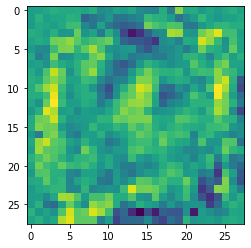

In [136]:
plt.imshow(w_fc1[9].reshape(28,28))
plt.show()

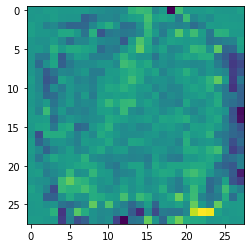

In [137]:
vis2 = np.matmul(w_fc2[8],w_fc1)
plt.imshow(vis2.reshape(28,28))
plt.show()

In [138]:
vis2.shape

(784,)


Label: 0


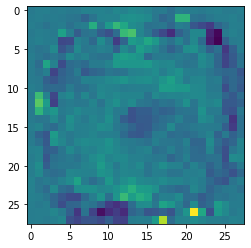


Label: 1


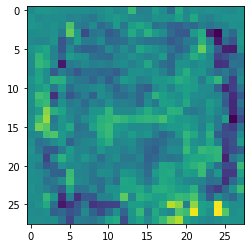


Label: 2


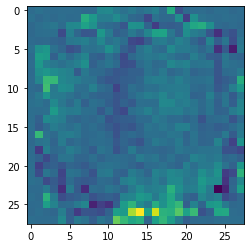


Label: 3


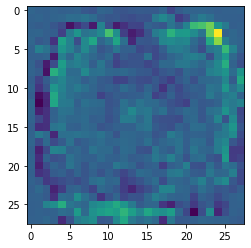


Label: 4


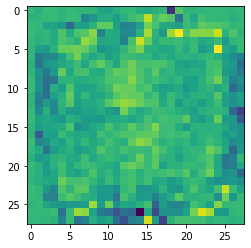


Label: 5


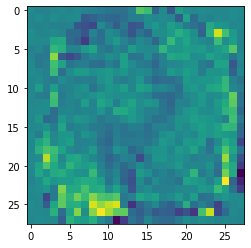


Label: 6


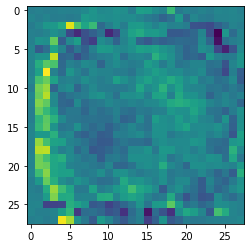


Label: 7


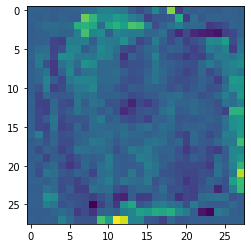


Label: 8


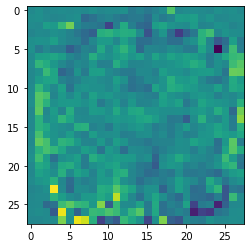


Label: 9


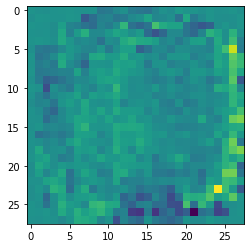

In [139]:
for ii in range(10):
    vis3 = np.matmul(w_fc3[ii],np.matmul(w_fc2,w_fc1))
    print("\nLabel:", ii)
    plt.imshow(vis3.reshape(784).reshape(28,28))
    plt.show()

In [13]:
# Retrieving model
MY_best_net = Net(784, 96, 24, 10, nn.modules.activation.Tanh)
MY_best_net.load_state_dict(torch.load("my_best_net.pkl"))

test_label = MY_best_net(torch.tensor(x_test)).float().detach().numpy()
#print(test_label)
test_label = np.argmax(test_label, axis=1)
#print(test_label)
#for ii in range(len(test_label)):
#    print(test_label[ii], y_test[ii])
print("Model accuracy:\t", np.mean(test_label==y_test.squeeze()))

Model accuracy:	 0.9711


# Nice results from a previous run


Label: 0


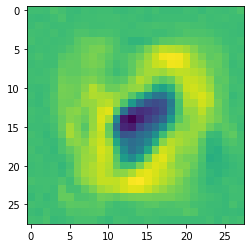


Label: 1


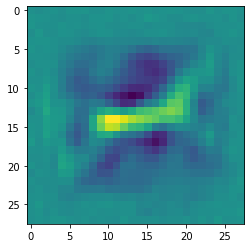


Label: 2


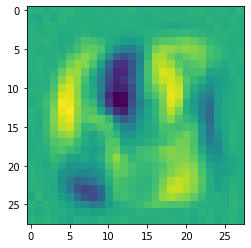


Label: 3


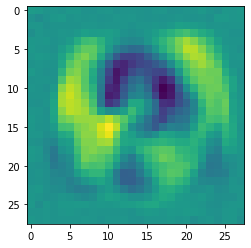


Label: 4


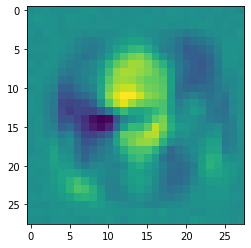


Label: 5


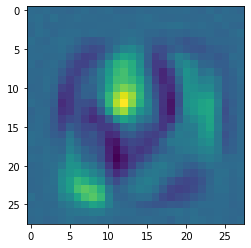


Label: 6


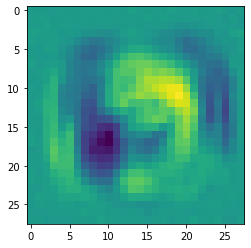


Label: 7


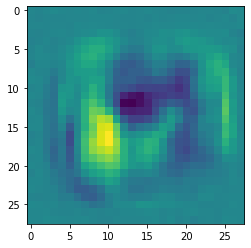


Label: 8


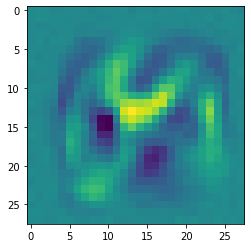


Label: 9


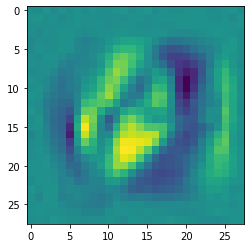

In [69]:
for ii in range(10):
    vis3 = np.matmul(w_fc3[ii],np.matmul(w_fc2,w_fc1))
    print("\nLabel:", ii)
    plt.imshow(vis3.reshape(784).reshape(28,28))
    plt.show()